### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

#physical_devices = tf.config.experimental.list_physical_devices()
#tf.config.experimental.set_memory_growth(physical_devices[2], True)

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000019EE18D30D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 9: Convolutional Neural Network (2D)

***

- The paper entitled "ESC-ConvNet: Environmental Sound Classification with Convolutional Neural Networks" (PICZAK, 2015) serves as the foundation for the following analysis. In this study, the author employs Convolutional Neural Networks (CNNs) for image classification, utilizing fixed dimension images that consist of multiple channels (such as RGB for color images). The network undergoes various stages of convolution, pooling, and fully connected layers, ultimately outputting class probabilities for the given image. With the aim to replicate this approach using sound clips, the utilization of log-scaled mel-spectrograms and their respective deltas from each sound clip is proposed instead of directly using the sound file as an amplitude vs. time signal. In order to address the requirement of fixed size input, the sound clips are segmented into 60x41 segments (60 bands and 44 frames - windowing techinique). The log-scaled mel-spectrograms are extracted from all the recordings, which were resampled to 22050 Hz and normalized with a window size of 1024, a hop length of 512, and 60 mel-bands.

- The human auditory system perceives sound on a logarithmic scale, rendering it difficult to distinguish closely-scaled frequencies. This effect becomes more pronounced with increasing frequency. Therefore, only the power within different frequency bands is considered. As a result, the mel-spectrograms and their corresponding deltas are transformed into two channels that are subsequently inputted into the CNN for analysis.

- During the iterative process of file exploration, it was noticed that each sound is 4, 5 or 10 seconds in duration and has in its duration (sometimes) silent periods. In order to achieve a more representative "sound image", for each sound, the "extract_feature" methods are utilized to trim the silent periods and duplicate the sound, effectively doubling its trimmed length (augmented audio). Subsequently, the aforementioned features, along with the class labels, are calculated and appended to arrays.

- The final result transformed the audio file into a spectrogram image consisting of 60 bands, 44 frames, and 2 channels. After a few cross-validations, it was confirmed the accuracy has improved when the deltas are aggreated to the image instead of using them as channels, therefore, the final image dimension was 180 (60 mels, 60 delta 1 and 60 delta 2) x 44 frames. 

## Import modules

In [2]:
import librosa
import librosa.display
import os
import warnings
import pickle
import itertools
import mimetypes
import time

import pandas     as pd
import seaborn    as sns
import numpy      as np

from matplotlib  import pyplot  as plt
from keras       import backend as K

from tqdm                        import tqdm

from sklearn                     import metrics
from sklearn.model_selection     import train_test_split
from sklearn.metrics             import confusion_matrix, classification_report

from tensorflow                  import keras
from tensorflow.keras.models     import Sequential, load_model
from tensorflow.keras.layers     import Dense, Dropout, Flatten, InputLayer, Conv2D
from tensorflow.keras.layers     import MaxPooling2D, BatchNormalization, Activation

from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks             import ModelCheckpoint, EarlyStopping
from keras.optimizers            import SGD
from keras.constraints           import maxnorm

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '09_CNN_2D_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

## Loading the dataset

In [4]:
# Select the dataset

opcD = 0
while str(opcD) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")

    opcD = input("\nSelect the dataset: ")
    if opcD.isdigit():
        opcD = int(opcD)
    else:
        opcD = 0

if opcD == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = 1
    dog_set     = 'Dog bark'
    
    pkl_features_CNN_2D          = 'ESC-10_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'ESC-10_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'ESC-10_features_CNN_2D_augmented.pkl'
    

    
if opcD == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'
    dog_set     = 'dogs'
    
    pkl_features_CNN_2D          = 'BDLib2_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'BDLib2_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'BDLib2_features_CNN_2D_augmented.pkl'
    
    
if opcD == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
        
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    dog_set     = 'dog_bark'

    pkl_features_CNN_2D          = 'US8K_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'US8K_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'US8K_features_CNN_2D_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    
    
if opcD == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)


    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'
    dog_set     = 'dog_bark'
    
    pkl_features_CNN_2D          = 'US8K_AV_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'US8K_AV_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'US8K_AV_features_CNN_2D_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [5]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [6]:
from MT_loadDataset import loadDataset

In [7]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
silence              550
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4908
Total number of AUDIO files...........:  4908


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path
0,5,fold5,"[0, 0, 0, 1, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav
1,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav
2,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav
3,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav
4,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav
...,...,...,...,...,...,...
4903,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_10.wav
4904,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_11.wav
4905,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_12.wav
4906,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_8.wav


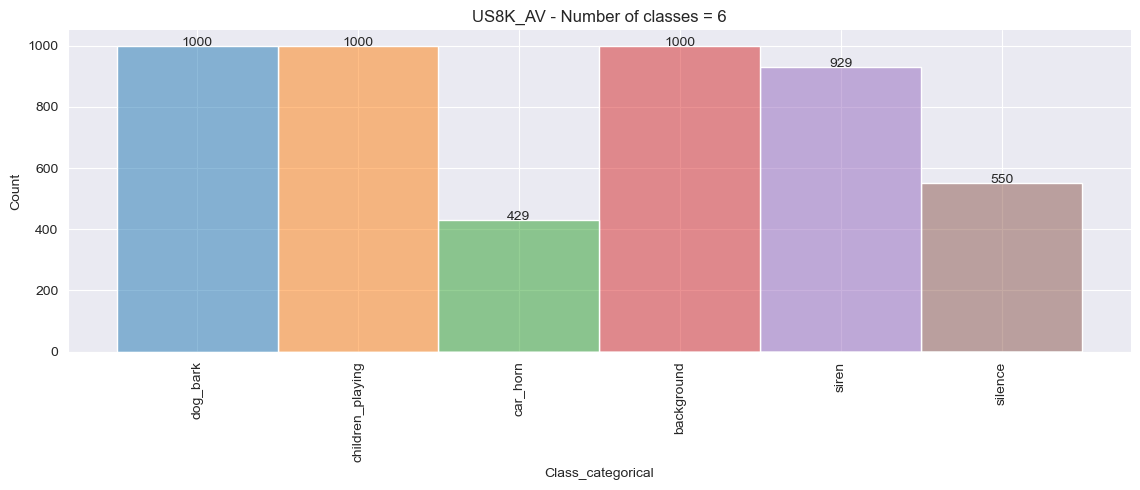

In [8]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [9]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K is only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_features_CNN_2D))
    model_surname    = '_original'

elif opc == 2:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_aug_features_CNN_2D))
    model_surname    = '_augmented'

elif opc == 3:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features_CNN_2D))
    model_surname    = '_windowed'
    
else:
    pass


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K is only windowed)

Select the dataset: 3


In [10]:
DB_from_pkl

,Class_categorical,Class_OHEV,Fold,features
0,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-44.0467643737793], [-39.25644302368164], [-38.62413787841797], [-36.58848571777344], [-32.5598030090332], [-31.4..."
1,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-29.934663772583008], [-34.787696838378906], [-40.06871795654297], [-41.22150802612305], [-41.03109359741211], [-..."
2,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-23.2158260345459], [-28.396337509155273], [-32.66521072387695], [-31.442462921142578], [-35.61741256713867], [-3..."
3,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-37.06025695800781], [-39.86629104614258], [-41.0966682434082], [-38.97296142578125], [-41.87018966674805], [-39...."
4,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-28.527423858642578], [-29.930322647094727], [-35.48342514038086], [-38.032806396484375], [-38.82895278930664], [..."
...,...,...,...,...
34351,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-28.725196838378906], [-21.75506591796875], [-15.691794395446777], [-11.686802864074707], [-13.252153396606445], ..."
34352,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-18.317378997802734], [-14.795974731445312], [-13.88856315612793], [-13.34511947631836], [-14.05569076538086], [-..."
34353,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-14.710319519042969], [-12.146648406982422], [-13.191940307617188], [-14.210320472717285], [-15.148565292358398],..."
34354,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-26.25575828552246], [-20.983177185058594], [-14.533549308776855], [-15.130903244018555], [-16.879596710205078], ..."


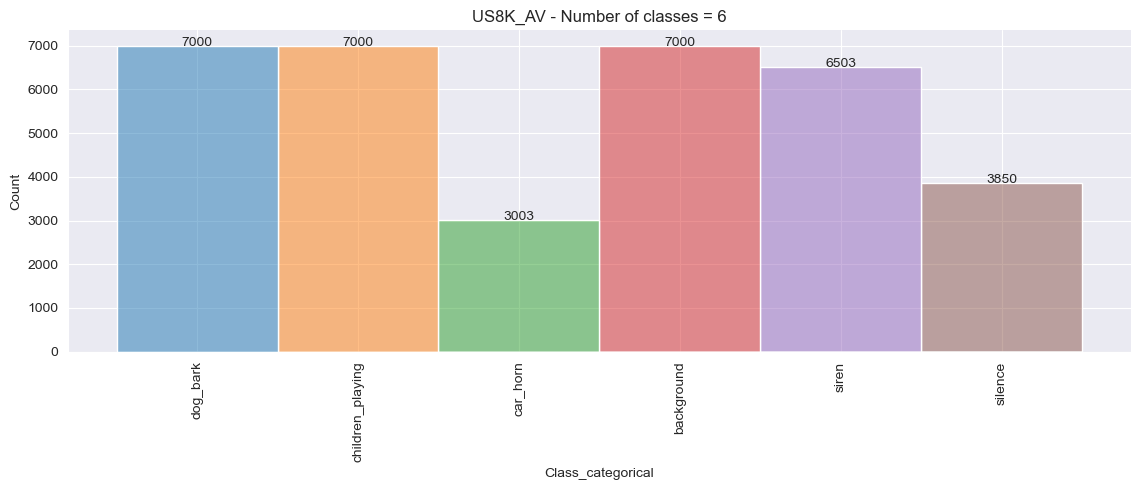

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [12]:
for fold in np.unique(DB_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_from_pkl[DB_from_pkl['Fold'] == fold])
    trnsize = len(DB_from_pkl[DB_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete_TRN size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 3346
dbComplete_TRN size: 31010

Validation fold: 10
dbComplete_VAL size: 3276
dbComplete_TRN size: 31080

Validation fold: 2
dbComplete_VAL size: 3395
dbComplete_TRN size: 30961

Validation fold: 3
dbComplete_VAL size: 3752
dbComplete_TRN size: 30604

Validation fold: 4
dbComplete_VAL size: 4193
dbComplete_TRN size: 30163

Validation fold: 5
dbComplete_VAL size: 3703
dbComplete_TRN size: 30653

Validation fold: 6
dbComplete_VAL size: 3220
dbComplete_TRN size: 31136

Validation fold: 7
dbComplete_VAL size: 3255
dbComplete_TRN size: 31101

Validation fold: 8
dbComplete_VAL size: 3087
dbComplete_TRN size: 31269

Validation fold: 9
dbComplete_VAL size: 3129
dbComplete_TRN size: 31227



In [13]:
# Set fold = '1' to train the model to be used in the ESR data preparation

fold = '1'
fold

'1'

In [14]:
DB_from_pkl.dtypes

Class_categorical    object
Class_OHEV           object
Fold                 object
features             object
dtype: object

In [15]:
DB_from_pkl['Class_OHEV'][0][0]

0

In [16]:
print(DB_from_pkl['Fold'].shape)
print(DB_from_pkl['Class_OHEV'][0].shape)
print(DB_from_pkl['features'][0].shape)

(34356,)
(6,)
(180, 44, 1)


In [17]:
print(type(DB_from_pkl['Fold'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0][0]))
print(type(DB_from_pkl['features'][0][0][0][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.float64'>


In [18]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         16034    [1, 0, 0, 0, 0, 0]
car_horn           26667    [0, 1, 0, 0, 0, 0]
children_playing   20586    [0, 0, 1, 0, 0, 0]
dog_bark           14196    [0, 0, 0, 1, 0, 0]
silence            32612    [0, 0, 0, 0, 1, 0]
siren              8968     [0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0]),
 'silence': array([0, 0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 0, 1])}

In [19]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

6

In [20]:
# Name of the classes

nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'silence', 'siren']

## Input split

In [21]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

X      = DB_from_pkl_TRN['features'].to_numpy()
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

X_val      = DB_from_pkl_VAL['features'].to_numpy()
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())


# Stackup and pass all values to float32
X = np.stack(X)
X = np.asarray(X).astype(np.float32)

X_val = np.stack(X_val)
X_val = np.asarray(X_val).astype(np.float32)

y_OHEV     = np.asarray(y_OHEV).astype(np.float32)
y_OHEV_val = np.asarray(y_OHEV_val).astype(np.float32)


# Retrieve the indexes used for training the classifiers
idx_trn = np.genfromtxt(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)
idx_tst = np.genfromtxt(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)

X_train      = X[idx_trn]
X_test       = X[idx_tst]
y_train      = y[idx_trn]
y_test       = y[idx_tst]
y_train_OHEV = y_OHEV[idx_trn]
y_test_OHEV  = y_OHEV[idx_tst]

In [22]:
idx_trn

array([ 1407, 16859,  5412, ...,  3926, 15590, 24914])

In [23]:
idx_tst

array([ 6025, 24431, 11398, ..., 30565, 25076, 10536])

In [24]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val...........: {np.shape(X_val)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (27909, 180, 44, 1)
y_train.........: (27909,)
y_train_OHEV....: (27909, 6)

Testing set

X_test..........: (3101, 180, 44, 1)
y_test..........: (3101,)
y_test_OHEV.....: (3101, 6)

Validation set

X_val...........: (3346, 180, 44, 1)
y_val...........: (3346,)
y_OHEV_val......: (3346, 6)


In [25]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [26]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

## Classifiers

- **Convolutional Neural Networks** (CNNs) are a class of deep learning algorithms specifically designed for processing grid-like data, such as images and videos. CNNs are highly effective in tasks related to computer vision, including image recognition, object detection, and image segmentation. They are characterized by their ability to automatically and adaptively learn spatial hierarchies of features from input data. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers apply convolution operations to the input data, enabling the network to automatically learn patterns and features from images, such as edges, textures, and more complex structures. The pooling layers downsample the spatial dimensions of the data, reducing computational complexity while retaining important features. Fully connected layers at the end of the network process the learned features and make predictions based on them. One of the significant advantages of CNNs is their ability to capture local patterns and spatial hierarchies of features. By using shared weights and biases in the convolutional layers, CNNs are capable of learning translation-invariant features, making them well-suited for tasks where the spatial arrangement of features in the input data is essential. Additionally, CNNs can automatically learn relevant features from raw pixel values, eliminating the need for manual feature extraction.

In [27]:
inputShape = X_train[0].shape
inputShape

(180, 44, 1)

In [28]:
# Architecture based on Su et al. (2019)

def basemodel_Su(model_name):
       
    model = Sequential(name = model_name)
    
    # Input is 44 x 180
    # If we have N x N image size and F x F filter size, afer the convolution the result will be
    # (N x N) * (F x F) = (N - F + 1) x (N - F + 1)
    # (44 - 7 + 1) x (180 - 7 + 1) = (38 x 174)
    
    model.add(Conv2D(32, (3, 3), input_shape=(inputShape), padding='same', strides=(2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten(name='Flatten'))

    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs  = 100
    lrate   = 0.001
    decay   = lrate/epochs
    sgd     = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [29]:
# Architecture based on Luz et al. (2021)

def basemodel_Luz(model_name):
       
    model = Sequential(name = model_name)
    
    model.add(Conv2D(24, (5, 5), input_shape=(inputShape), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten(name='Flatten'))

    model.add(Dense(64, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs  = 100
    lrate   = 0.001
    decay   = lrate/epochs
    sgd     = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [30]:
monitor = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)

filepath       = os.path.join(path_models, 'Model_CNN_2D_weights_0_best' + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, monitor]

In [31]:
# Select the model

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Architecture based on Su et al. (2019)")
    print("2-) Architecture based on Luz et al. (2021)")

    opc = input("\nSelect the model: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    basemodel = basemodel_Su
    surName = '_Su'

elif opc == 2:
    basemodel = basemodel_Luz
    surName = '_Luz'

else:
    pass

Model_CNN_2D = basemodel('Model_CNN_2D' + surName)
print(Model_CNN_2D.summary())


1-) Architecture based on Su et al. (2019)
2-) Architecture based on Luz et al. (2021)

Select the model: 1
Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
________

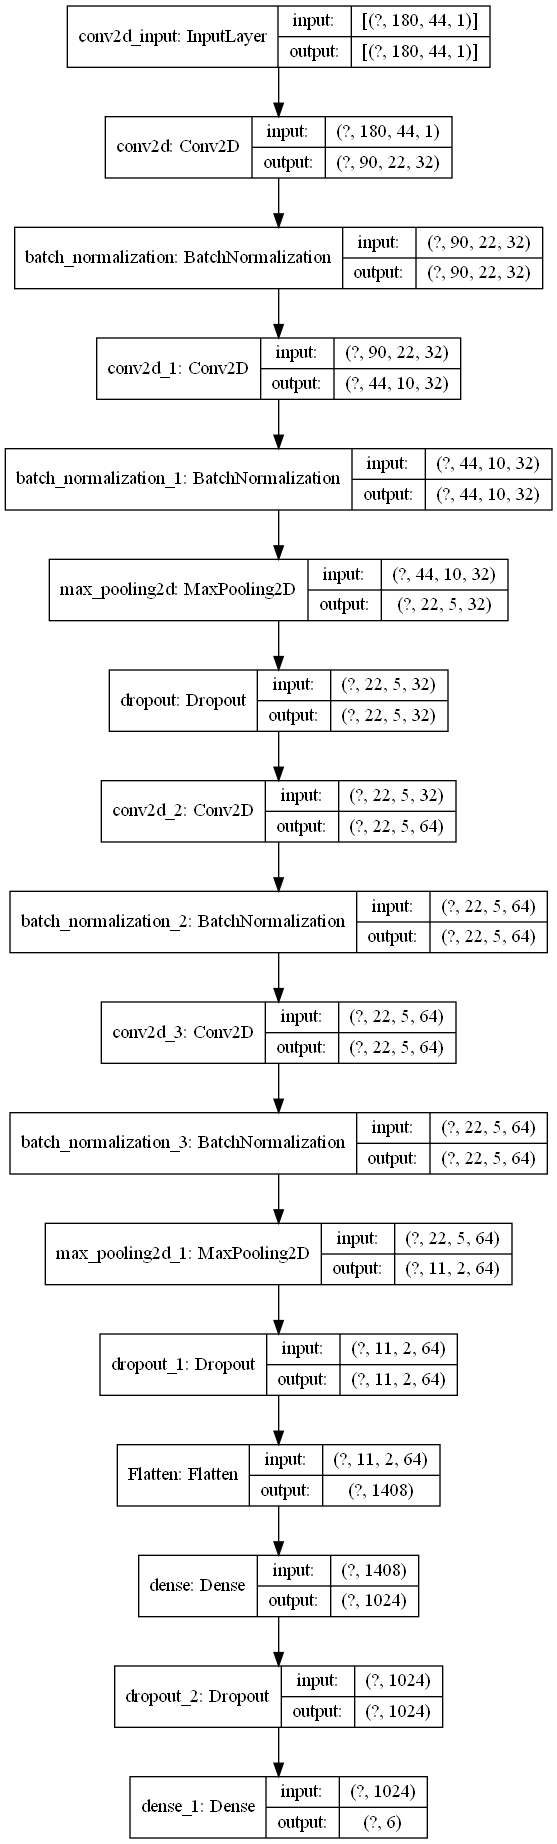

In [32]:
tf.keras.utils.plot_model(Model_CNN_2D, to_file= os.path.join(path_models, 'Model_CNN_2D' + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

1. For `Conv1D` layer:
   - The number of parameters for a `Conv1D` layer is calculated as `(kernel_size * input_channels + 1) * output_channels`, where `kernel_size` is the size of the convolutional kernel, `input_channels` is the number of input channels (1 in this case), and `output_channels` is the number of output channels.

2. For `Dense` layer:
   - The number of parameters for a `Dense` layer is calculated as `(input_units + 1) * output_units`, where `input_units` is the number of input units and `output_units` is the number of output units.
   
3. In the calculation of parameters for a convolutional layer, the term "channels" refers to the number of filters used in that layer.
4. Params = (filter_height * filter_width * input_channels + 1) * number_of_filters


- 624   parameters is the result of 24 filters * (5 kernels * 5 kernels * 1 channel + 1)
- 28,848 parameters is the result of 48 filter * (5 kernels * 5 kernels * 24 channels + 1)
- 57,648 parameters is the result of 48 filter * (5 kernels * 5 kernels * 48 channels + 1)
- 57,648 parameters is the result of 48 filter * (5 kernels * 5 kernels * 48 channels + 1)
- 67,648  parameters is the result of 64 neurons with 1,056 features + 64 bias values
- 8,320  parameters is the result of 128 neurons with 64 features + 128 bias values
- 645  parameters is the result of 5 neurons with 128 features + 5 bias values

### CNN 2D adjustments

In [33]:
print("\n========================================================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)} ...type: {type(X_train[0][0][0][0])}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)} ............type: {type(y_train_OHEV[0][0])}')

print("\n========================================================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)} ....type: {type(X_test[0][0][0][0])}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)} .............type: {type(y_test_OHEV[0][0])}')

print("\n========================================================================")
print("Validation set\n")

print(f'X_val...........: {np.shape(X_val)} ....type: {type(X_val[0][0][0][0])}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)} .............type: {type(y_OHEV_val[0][0])}')


Training set

X_train.........: (27909, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27909, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3101, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3101, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3346, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3346, 6) .............type: <class 'numpy.float32'>


In [34]:
batch_size = 32
epochs     = 100

In [35]:
batch_size = 32
epochs     = 100
history    = Model_CNN_2D.fit(X_train, y_train_OHEV,
                              batch_size      = batch_size,
                              epochs          = epochs,
                              verbose         = 1,
                              validation_data = (X_test, y_test_OHEV),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              callbacks       = callbacks_list,
                              use_multiprocessing = True)

Epoch 1/100
873/873 [==============================] - ETA: 0s - loss: 1.2542 - accuracy: 0.5870
Epoch 00001: val_accuracy improved from -inf to 0.72815, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 7s 8ms/step - loss: 1.2542 - accuracy: 0.5870 - val_loss: 0.7507 - val_accuracy: 0.7282
Epoch 2/100
867/873 [============================>.] - ETA: 0s - loss: 0.8446 - accuracy: 0.6985
Epoch 00002: val_accuracy did not improve from 0.72815
873/873 [==============================] - 6s 7ms/step - loss: 0.8443 - accuracy: 0.6987 - val_loss: 1.0956 - val_accuracy: 0.6356
Epoch 3/100
870/873 [============================>.] - ETA: 0s - loss: 0.7392 - accuracy: 0.7348
Epoch 00003: val_accuracy improved from 0.72815 to 0.78136, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hd

865/873 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.8799
Epoch 00024: val_accuracy did not improve from 0.91874
873/873 [==============================] - 6s 7ms/step - loss: 0.3348 - accuracy: 0.8799 - val_loss: 0.2724 - val_accuracy: 0.9023
Epoch 25/100
865/873 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.8842
Epoch 00025: val_accuracy improved from 0.91874 to 0.92744, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.3284 - accuracy: 0.8843 - val_loss: 0.2179 - val_accuracy: 0.9274
Epoch 26/100
872/873 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8854
Epoch 00026: val_accuracy did not improve from 0.92744
873/873 [==============================] - 6s 7ms/step - loss: 0.3225 - accuracy: 0.8853 - val_loss: 0.2426 - val_accuracy: 0.9194
Epoch 27/100
865/

Epoch 48/100
872/873 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9170
Epoch 00048: val_accuracy did not improve from 0.95421
873/873 [==============================] - 6s 7ms/step - loss: 0.2294 - accuracy: 0.9169 - val_loss: 0.2238 - val_accuracy: 0.9194
Epoch 49/100
872/873 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9176
Epoch 00049: val_accuracy did not improve from 0.95421
873/873 [==============================] - 6s 7ms/step - loss: 0.2296 - accuracy: 0.9176 - val_loss: 0.1547 - val_accuracy: 0.9503
Epoch 50/100
872/873 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9200
Epoch 00050: val_accuracy did not improve from 0.95421
873/873 [==============================] - 6s 7ms/step - loss: 0.2197 - accuracy: 0.9200 - val_loss: 0.1849 - val_accuracy: 0.9410
Epoch 51/100
872/873 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9213
Epoch 00051: val_accuracy did not improve from 0.9

Epoch 75/100
866/873 [============================>.] - ETA: 0s - loss: 0.1766 - accuracy: 0.9376
Epoch 00075: val_accuracy did not improve from 0.96453
873/873 [==============================] - 6s 7ms/step - loss: 0.1762 - accuracy: 0.9377 - val_loss: 0.1299 - val_accuracy: 0.9587
Epoch 76/100
872/873 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9391
Epoch 00076: val_accuracy improved from 0.96453 to 0.96775, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.1719 - accuracy: 0.9392 - val_loss: 0.1080 - val_accuracy: 0.9678
Epoch 77/100
872/873 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9383
Epoch 00077: val_accuracy did not improve from 0.96775
873/873 [==============================] - 6s 7ms/step - loss: 0.1705 - accuracy: 0.9383 - val_loss: 0.1307 - val_accuracy: 0.9613
Epoc

In [36]:
score_CNN_2D = Model_CNN_2D.evaluate(X_val, y_OHEV_val, verbose=1, batch_size = batch_size)
print('Test loss:', score_CNN_2D[0])
print('Test accuracy:', score_CNN_2D[1])

105/105 [==============================] - 0s 3ms/step - loss: 0.8634 - accuracy: 0.8144
Test loss: 0.8634234070777893
Test accuracy: 0.8144052624702454


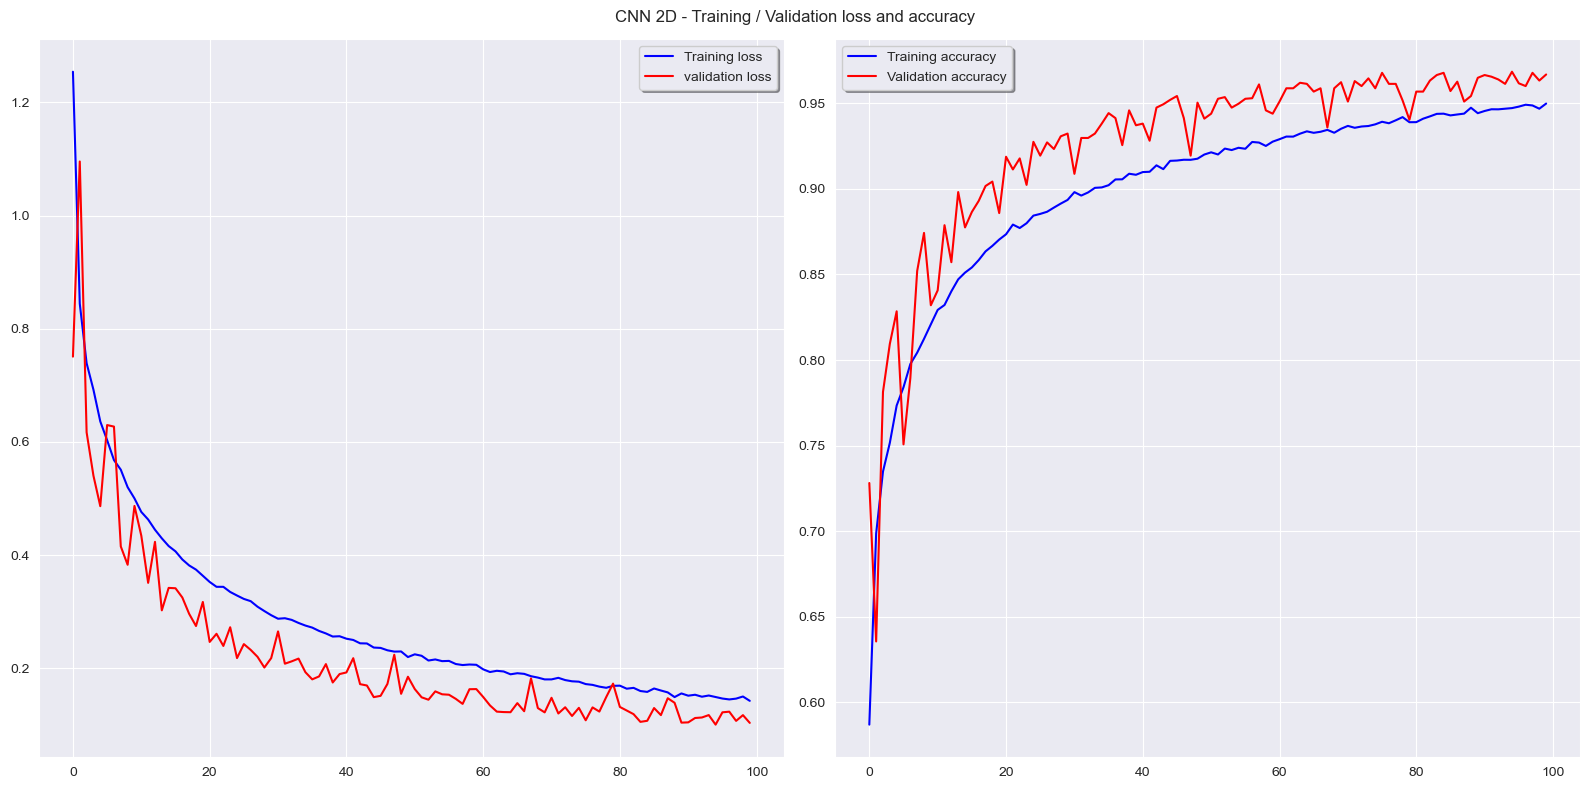

In [37]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('CNN 2D - Training / Validation loss and accuracy')
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [38]:
# save model and architecture to single file (not the best model though)

# Model_CNN_2D.save(os.path.join(path_models, "Model_CNN_2D.hdf5"))
# print("Saved model to disk")

In [39]:
y_pred_CNN_2d = np.argmax(Model_CNN_2D.predict(X_val),axis=1)
y_pred_CNN_2d

array([3, 3, 3, ..., 5, 5, 5], dtype=int64)

In [40]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 4, 4, 4], dtype=int64)

In [41]:
score_CNN_2D[1]

0.8144052624702454

In [42]:
metrics_set_CNN_2D = classification_report(y_test_enc, y_pred_CNN_2d, target_names=nom_classes)
print(metrics_set_CNN_2D)

                  precision    recall  f1-score   support

      background       0.83      0.81      0.82       756
        car_horn       0.86      0.80      0.83       252
children_playing       0.67      0.89      0.77       700
        dog_bark       0.85      0.77      0.81       700
         silence       0.88      0.90      0.89       336
           siren       0.94      0.74      0.83       602

        accuracy                           0.81      3346
       macro avg       0.84      0.82      0.82      3346
    weighted avg       0.83      0.81      0.82      3346



In [43]:
# Load the model with the highest accuracy
# This model will be used in the notebook 10_ESR_data_preparation.ipynb

# Architecture based on Su et al. (2019)
# This model was saved after the training rather than using the best model saved during the training.

Model_CNN_2D_saved = load_model(os.path.join(path_models, 'Model_CNN_2D.hdf5'))
Model_CNN_2D_saved.summary()

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 5, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 5, 64)     

In [44]:
score_CNN_2D_saved = Model_CNN_2D_saved.evaluate(X_val, y_OHEV_val, verbose=1, batch_size = batch_size)
print('Test loss:', score_CNN_2D_saved[0])
print('Test accuracy:', score_CNN_2D_saved[1])

105/105 [==============================] - 0s 3ms/step - loss: 0.8453 - accuracy: 0.8171
Test loss: 0.8452977538108826
Test accuracy: 0.8170950412750244


In [45]:
y_pred_CNN_2D_saved = np.argmax(Model_CNN_2D_saved.predict(X_val),axis=1)
y_pred_CNN_2D_saved

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [46]:
prob = np.round(Model_CNN_2D_saved.predict(X_val)[7],6)
for i in prob:
    print(i)

2.3e-05
0.0
3e-06
0.999896
7.8e-05
0.0


In [47]:
metrics_set_CNN_2D_saved = classification_report(y_test_enc, y_pred_CNN_2D_saved, target_names=nom_classes)
print(metrics_set_CNN_2D_saved)

                  precision    recall  f1-score   support

      background       0.83      0.78      0.81       756
        car_horn       0.86      0.81      0.83       252
children_playing       0.72      0.82      0.77       700
        dog_bark       0.83      0.80      0.81       700
         silence       0.78      0.96      0.86       336
           siren       0.94      0.80      0.87       602

        accuracy                           0.82      3346
       macro avg       0.83      0.83      0.82      3346
    weighted avg       0.82      0.82      0.82      3346



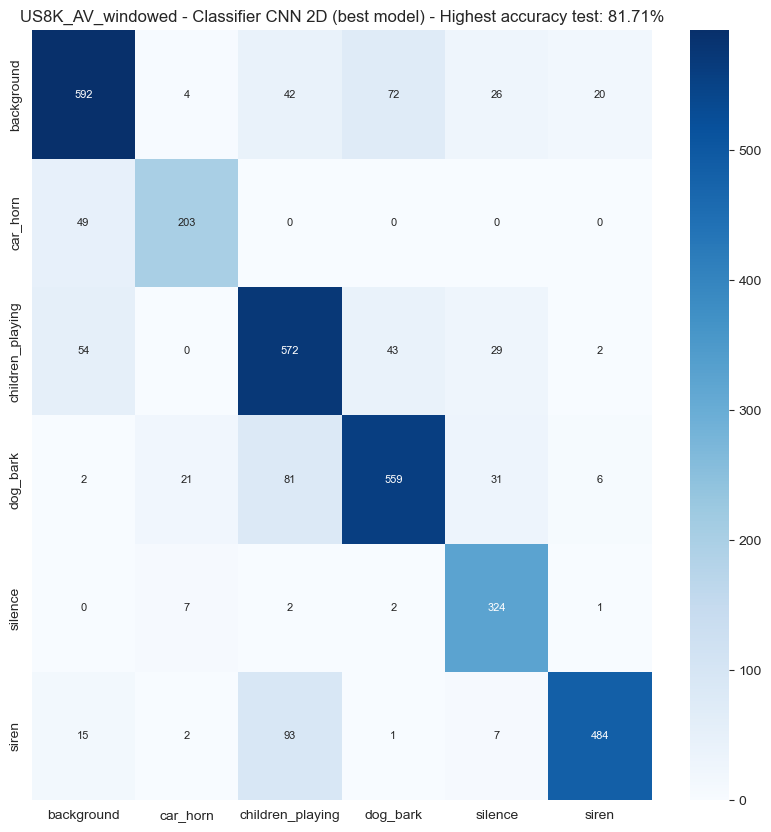

In [48]:
# Simple confusion matrix
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_CNN_2D_saved)
title = nom_dataset + model_surname + ' - Classifier CNN 2D (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_CNN_2D_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [49]:
Model_CNN_2D_saved.layers

In [50]:
for layer in Model_CNN_2D_saved.layers:
    print(layer.get_weights())

[array([[[[-0.37888294,  0.05054501,  0.1170817 ,  0.3940512 ,
           0.05344284, -0.10861577, -0.11463294,  0.0280117 ,
          -0.11823265,  0.18400267, -0.43288743,  0.00533085,
           0.17850879, -0.01922712, -0.04797594, -0.11049446,
          -0.07725666, -0.0285665 , -0.43703052,  0.13192865,
          -0.24487688,  0.04964166,  0.05939614,  0.44480827,
           0.1807613 , -0.48298037, -0.16236646,  0.3758791 ,
           0.0779573 ,  0.05552559, -0.3925779 ,  0.09337605]],

        [[-0.22073056, -0.06062178, -0.02605549,  0.40574905,
           0.01367573,  0.10369164, -0.09564953, -0.01981244,
          -0.01911084,  0.22497283, -0.531744  ,  0.10778108,
           0.044729  ,  0.03654694, -0.09224875,  0.05022788,
          -0.1036434 ,  0.09251997, -0.3825407 ,  0.2779429 ,
          -0.24811147, -0.00838349, -0.07867223,  0.33576834,
           0.02175467, -0.2973779 , -0.12775505,  0.34404057,
           0.09140316,  0.10580628, -0.33452994,  0.17913479]],

 

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [51]:
classifiers = ['Model_CNN_2D_Su', 'Model_CNN_2D_Luz']

In [52]:
# Pipeline to run the classifiers and their metrics

def model_classifiers(classifiers:list, db: pd.DataFrame):
    
    # Clear the session to start a new training
    K.clear_session()
                      
    monitor = EarlyStopping(monitor='val_accuracy', 
                        min_delta = 0.0001, 
                        patience = 20, 
                        verbose = 1, 
                        mode = 'auto', 
                        restore_best_weights = True)
                      
    count       = 1
    verbose     = True
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Val)',
                                                    'F1(Train)',
                                                    'F1(Val)', 
                                                    'Precision(Train)',
                                                    'Precision(Val)', 
                                                    'Recall(Train)',
                                                    'Recall(Val)', 
                                                    'Conf_M',
                                                    'Process_time',                                                     
                                                    'Class_report(Val)'])
                      
    for fold in np.unique(db['Fold']):
        print(f"\nValidation fold: {fold}")

        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]

        X      = DB_TRN['features'].to_numpy()
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL['features'].to_numpy()
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())


        # Stackup and pass all values to float32
        X = np.stack(X)
        X = np.asarray(X).astype(np.float32)

        X_val = np.stack(X_val)
        X_val = np.asarray(X_val).astype(np.float32)

        y_OHEV     = np.asarray(y_OHEV).astype(np.float32)
        y_OHEV_val = np.asarray(y_OHEV_val).astype(np.float32)

        X_train_final, X_test, y_train_final, y_test = train_test_split(X,
                                                                        y_OHEV, 
                                                                        test_size = 0.1, 
                                                                        random_state = 100, 
                                                                        stratify = y_OHEV)
        
        print("\n========================================================================")
        print("Training set\n")

        print(f'X_train.........: {np.shape(X_train_final)} ...type: {type(X_train_final[0][0][0][0])}')
        print(f'y_train_OHEV....: {np.shape(y_train_final)} ............type: {type(y_train_final[0][0])}')

        print("\n========================================================================")
        print("Testing set\n")

        print(f'X_test..........: {np.shape(X_test)} ....type: {type(X_test[0][0][0][0])}')
        print(f'y_test_OHEV.....: {np.shape(y_test)} .............type: {type(y_test[0][0])}')

        print("\n========================================================================")
        print("Validation set\n")

        print(f'X_val...........: {np.shape(X_val)} ....type: {type(X_val[0][0][0][0])}')
        print(f'y_OHEV_val......: {np.shape(y_OHEV_val)} .............type: {type(y_OHEV_val[0][0])}')
        print()

        
        for i in tqdm(range(len(classifiers))):
            
            name         = classifiers[i]
            model_name   = (classifiers[i] + '_' + str(count))
            count        = count + 1
            
            if not os.path.exists(path_models):
                os.makedirs(path_models)

            filepath       = os.path.join(path_models, classifiers[i] + '_weights_0_best' + model_surname + '.hdf5')
            checkpoint     = ModelCheckpoint(filepath, 
                                             monitor = 'val_accuracy', 
                                             verbose = 1, 
                                             save_best_only = True, 
                                             mode = 'max')
            callbacks_list = [checkpoint, monitor]

            if classifiers[i] == 'Model_CNN_2D_Su':
                model = basemodel_Su(classifiers[i])
                model.summary()
                print(model_name)
            
            elif classifiers[i] == 'Model_CNN_2D_Luz':
                model = basemodel_Luz(classifiers[i])
                model.summary()
                print(model_name)
            else:
                pass


            model.fit(X_train_final, 
                      y_train_final,
                      batch_size          = batch_size,
                      epochs              = epochs,
                      verbose             = 1,
                      validation_data     = (X_test, y_test),
                      steps_per_epoch     = int(np.ceil(X_train_final.shape[0] / float(batch_size))),
                      callbacks           = callbacks_list,
                      use_multiprocessing = True)
                      
            # Get the model predictions
            y_train_enc = np.argmax(y_train_final, axis=1)
            y_val_enc   = np.argmax(y_OHEV_val, axis=1)

            y_train_predicted = np.argmax(model.predict(X_train_final), axis=1)

            t_srt             = time.process_time_ns()
            y_val_predicted   = np.argmax(model.predict(X_val), axis=1)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)   
            
            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y_train_enc, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val_enc,  y_val_predicted)

            f1_Score_train = metrics.f1_score(y_train_enc, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            precision_score_train = metrics.precision_score(y_train_enc, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            recall_score_train = metrics.recall_score(y_train_enc, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            class_report_val = classification_report(y_val_enc, y_val_predicted, target_names = nom_classes)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val_enc, y_val_predicted)
            y_val_enc       = []
            y_val_predicted = []

            # Store the name, test accuracy results and model
            models.append((name, accuracy_val, model))
            
            K.clear_session()
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Val)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Val)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Val)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Val)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time],
                                                        'Class_report(Val)': class_report_val})], ignore_index = True)
                   
    return acc_set, models

In [53]:
metrics_set, models_set  = model_classifiers(classifiers, DB_from_pkl)


Validation fold: 1

Training set

X_train.........: (27909, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27909, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3101, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3101, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3346, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3346, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 15/100
870/873 [============================>.] - ETA: 0s - loss: 0.4156 - accuracy: 0.8523
Epoch 00015: val_accuracy improved from 0.89391 to 0.89552, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.4157 - accuracy: 0.8522 - val_loss: 0.2989 - val_accuracy: 0.8955
Epoch 16/100
872/873 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8540
Epoch 00016: val_accuracy improved from 0.89552 to 0.90906, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.4086 - accuracy: 0.8541 - val_loss: 0.2717 - val_accuracy: 0.9091
Epoch 17/100
871/873 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.8610
Epoch 00017: val_accuracy did not improv

Epoch 39/100
865/873 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.9086
Epoch 00039: val_accuracy did not improve from 0.94421
873/873 [==============================] - 6s 7ms/step - loss: 0.2564 - accuracy: 0.9087 - val_loss: 0.1698 - val_accuracy: 0.9397
Epoch 40/100
872/873 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9115
Epoch 00040: val_accuracy did not improve from 0.94421
873/873 [==============================] - 6s 7ms/step - loss: 0.2454 - accuracy: 0.9115 - val_loss: 0.1793 - val_accuracy: 0.9387
Epoch 41/100
872/873 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9121
Epoch 00041: val_accuracy did not improve from 0.94421
873/873 [==============================] - 6s 7ms/step - loss: 0.2450 - accuracy: 0.9121 - val_loss: 0.1674 - val_accuracy: 0.9410
Epoch 42/100
871/873 [============================>.] - ETA: 0s - loss: 0.2430 - accuracy: 0.9144
Epoch 00042: val_accuracy did not improve from 0.9

Epoch 64/100
865/873 [============================>.] - ETA: 0s - loss: 0.1853 - accuracy: 0.9358
Epoch 00064: val_accuracy did not improve from 0.96034
873/873 [==============================] - 6s 7ms/step - loss: 0.1849 - accuracy: 0.9359 - val_loss: 0.1191 - val_accuracy: 0.9587
Epoch 65/100
865/873 [============================>.] - ETA: 0s - loss: 0.1866 - accuracy: 0.9325
Epoch 00065: val_accuracy improved from 0.96034 to 0.96195, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
873/873 [==============================] - 6s 7ms/step - loss: 0.1861 - accuracy: 0.9326 - val_loss: 0.1133 - val_accuracy: 0.9619
Epoch 66/100
865/873 [============================>.] - ETA: 0s - loss: 0.1846 - accuracy: 0.9342
Epoch 00066: val_accuracy did not improve from 0.96195
873/873 [==============================] - 6s 7ms/step - loss: 0.1847 - accuracy: 0.9343 - val_loss: 0.1165 - val_accuracy: 0.9600
E

Epoch 91/100
871/873 [============================>.] - ETA: 0s - loss: 0.1509 - accuracy: 0.9458
Epoch 00091: val_accuracy did not improve from 0.97001
873/873 [==============================] - 6s 7ms/step - loss: 0.1509 - accuracy: 0.9458 - val_loss: 0.0962 - val_accuracy: 0.9678
Epoch 92/100
865/873 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9487
Epoch 00092: val_accuracy did not improve from 0.97001
873/873 [==============================] - 6s 7ms/step - loss: 0.1475 - accuracy: 0.9490 - val_loss: 0.0938 - val_accuracy: 0.9655
Epoch 93/100
871/873 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9484
Epoch 00093: val_accuracy did not improve from 0.97001
873/873 [==============================] - 6s 7ms/step - loss: 0.1477 - accuracy: 0.9484 - val_loss: 0.0971 - val_accuracy: 0.9671
Epoch 94/100
865/873 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9480
Epoch 00094: val_accuracy did not improve from 0.9

 50%|█████████████████████████████████████████▌                                         | 1/2 [10:01<10:01, 601.99s/it]

                  precision    recall  f1-score   support

      background       0.80      0.80      0.80       756
        car_horn       0.84      0.82      0.83       252
children_playing       0.72      0.83      0.77       700
        dog_bark       0.81      0.80      0.80       700
         silence       0.78      0.84      0.81       336
           siren       0.94      0.77      0.85       602

        accuracy                           0.81      3346
       macro avg       0.82      0.81      0.81      3346
    weighted avg       0.81      0.81      0.81      3346

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 15/100
873/873 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9656
Epoch 00015: val_accuracy did not improve from 0.95389
873/873 [==============================] - 15s 17ms/step - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.2352 - val_accuracy: 0.9332
Epoch 16/100
872/873 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9684
Epoch 00016: val_accuracy improved from 0.95389 to 0.96453, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
873/873 [==============================] - 15s 17ms/step - loss: 0.0967 - accuracy: 0.9683 - val_loss: 0.1238 - val_accuracy: 0.9645
Epoch 17/100
872/873 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9700
Epoch 00017: val_accuracy did not improve from 0.96453
873/873 [==============================] - 15s 17ms/step - loss: 0.0883 - accuracy: 0.9700 - val_loss: 0.1251 - val_accuracy: 0

Epoch 42/100
872/873 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9942
Epoch 00042: val_accuracy did not improve from 0.97194
873/873 [==============================] - 15s 17ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.1694 - val_accuracy: 0.9639
Epoch 43/100
872/873 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9951
Epoch 00043: val_accuracy improved from 0.97194 to 0.97323, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
873/873 [==============================] - 15s 17ms/step - loss: 0.0141 - accuracy: 0.9951 - val_loss: 0.1314 - val_accuracy: 0.9732
Epoch 44/100
870/873 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9931
Epoch 00044: val_accuracy did not improve from 0.97323
873/873 [==============================] - 15s 17ms/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.1468 - val_accuracy: 0

Epoch 70/100
870/873 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9907
Epoch 00070: val_accuracy did not improve from 0.97678
873/873 [==============================] - 15s 17ms/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.1530 - val_accuracy: 0.9687
Epoch 71/100
872/873 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9963
Epoch 00071: val_accuracy did not improve from 0.97678
873/873 [==============================] - 15s 17ms/step - loss: 0.0108 - accuracy: 0.9963 - val_loss: 0.1436 - val_accuracy: 0.9723
Epoch 72/100
872/873 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9970
Epoch 00072: val_accuracy did not improve from 0.97678
873/873 [==============================] - 15s 17ms/step - loss: 0.0088 - accuracy: 0.9970 - val_loss: 0.1546 - val_accuracy: 0.9713
Epoch 73/100
870/873 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9972
Epoch 00073: val_accuracy did not improve fr

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [29:35<00:00, 887.85s/it]

                  precision    recall  f1-score   support

      background       0.81      0.76      0.78       756
        car_horn       0.90      0.81      0.85       252
children_playing       0.71      0.84      0.77       700
        dog_bark       0.63      0.84      0.72       700
         silence       0.78      0.36      0.49       336
           siren       0.93      0.75      0.83       602

        accuracy                           0.76      3346
       macro avg       0.79      0.73      0.74      3346
    weighted avg       0.78      0.76      0.75      3346


Validation fold: 10



Training set

X_train.........: (27972, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27972, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3108, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3108, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3276, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3276, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 17/100
869/875 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.8584
Epoch 00017: val_accuracy improved from 0.89350 to 0.90734, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.3981 - accuracy: 0.8581 - val_loss: 0.2788 - val_accuracy: 0.9073
Epoch 18/100
872/875 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8575
Epoch 00018: val_accuracy did not improve from 0.90734
875/875 [==============================] - 6s 7ms/step - loss: 0.3910 - accuracy: 0.8573 - val_loss: 0.3051 - val_accuracy: 0.8970
Epoch 19/100
868/875 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8675
Epoch 00019: val_accuracy did not improve from 0.90734
875/875 [==============================] - 6s 7ms/step - loss: 0.3754 - accuracy: 0.8673 - val_loss: 0.2752 - val_accuracy: 0.9064
E

Epoch 41/100
871/875 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.9129
Epoch 00041: val_accuracy improved from 0.93308 to 0.94112, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.2493 - accuracy: 0.9128 - val_loss: 0.1830 - val_accuracy: 0.9411
Epoch 42/100
874/875 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9128
Epoch 00042: val_accuracy did not improve from 0.94112
875/875 [==============================] - 6s 7ms/step - loss: 0.2474 - accuracy: 0.9128 - val_loss: 0.1909 - val_accuracy: 0.9382
Epoch 43/100
870/875 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9116
Epoch 00043: val_accuracy improved from 0.94112 to 0.94337, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

871/875 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9343
Epoch 00066: val_accuracy improved from 0.95624 to 0.95656, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.1842 - accuracy: 0.9343 - val_loss: 0.1495 - val_accuracy: 0.9566
Epoch 67/100
871/875 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9345
Epoch 00067: val_accuracy did not improve from 0.95656
875/875 [==============================] - 6s 7ms/step - loss: 0.1831 - accuracy: 0.9344 - val_loss: 0.1407 - val_accuracy: 0.9543
Epoch 68/100
873/875 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9335
Epoch 00068: val_accuracy improved from 0.95656 to 0.96042, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf

Epoch 92/100
871/875 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9444
Epoch 00092: val_accuracy did not improve from 0.96525
875/875 [==============================] - 6s 7ms/step - loss: 0.1580 - accuracy: 0.9443 - val_loss: 0.1195 - val_accuracy: 0.9620
Epoch 93/100
869/875 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9448
Epoch 00093: val_accuracy did not improve from 0.96525
875/875 [==============================] - 6s 7ms/step - loss: 0.1552 - accuracy: 0.9449 - val_loss: 0.1149 - val_accuracy: 0.9636
Epoch 94/100
872/875 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9482
Epoch 00094: val_accuracy did not improve from 0.96525
875/875 [==============================] - 6s 7ms/step - loss: 0.1487 - accuracy: 0.9480 - val_loss: 0.1179 - val_accuracy: 0.9640
Epoch 95/100
871/875 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9461
Epoch 00095: val_accuracy did not improve from 0.9

 50%|█████████████████████████████████████████▌                                         | 1/2 [09:47<09:47, 587.16s/it]

                  precision    recall  f1-score   support

      background       0.82      0.86      0.84       721
        car_horn       0.96      0.89      0.92       231
children_playing       0.67      0.88      0.76       700
        dog_bark       0.64      0.74      0.69       700
         silence       0.90      0.60      0.72       343
           siren       0.91      0.55      0.68       581

        accuracy                           0.76      3276
       macro avg       0.82      0.75      0.77      3276
    weighted avg       0.78      0.76      0.76      3276

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 15/100
873/875 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9660
Epoch 00015: val_accuracy did not improve from 0.94788
875/875 [==============================] - 15s 17ms/step - loss: 0.1044 - accuracy: 0.9660 - val_loss: 0.2232 - val_accuracy: 0.9366
Epoch 16/100
873/875 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9679
Epoch 00016: val_accuracy did not improve from 0.94788
875/875 [==============================] - 15s 17ms/step - loss: 0.0984 - accuracy: 0.9678 - val_loss: 0.2210 - val_accuracy: 0.9295
Epoch 17/100
874/875 [============================>.] - ETA: 0s - loss: 0.0939 - accuracy: 0.9698
Epoch 00017: val_accuracy improved from 0.94788 to 0.95978, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
875/875 [==============================] - 15s 17ms/step - loss: 0.0939 - accuracy: 0.9697 - val_loss: 0.1456 - val_accuracy: 0

Epoch 41/100
875/875 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9921
Epoch 00041: val_accuracy did not improve from 0.96718
875/875 [==============================] - 15s 17ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.1619 - val_accuracy: 0.9627
Epoch 42/100
874/875 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9925
Epoch 00042: val_accuracy did not improve from 0.96718
875/875 [==============================] - 15s 17ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.1504 - val_accuracy: 0.9665
Epoch 43/100
873/875 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9928
Epoch 00043: val_accuracy improved from 0.96718 to 0.96943, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
875/875 [==============================] - 15s 17ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.1356 - val_accuracy: 0

Epoch 68/100
872/875 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9976
Epoch 00068: val_accuracy did not improve from 0.97329
875/875 [==============================] - 15s 17ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.1611 - val_accuracy: 0.9691
Epoch 69/100
874/875 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9976
Epoch 00069: val_accuracy did not improve from 0.97329
875/875 [==============================] - 15s 17ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.1547 - val_accuracy: 0.9717
Epoch 70/100
874/875 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9982
Epoch 00070: val_accuracy did not improve from 0.97329
875/875 [==============================] - 15s 17ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.1759 - val_accuracy: 0.9694
Epoch 71/100
874/875 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9976
Epoch 00071: val_accuracy did not improve fr

875/875 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9978
Epoch 00095: val_accuracy did not improve from 0.97651
875/875 [==============================] - 15s 17ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.1809 - val_accuracy: 0.9688
Epoch 96/100
872/875 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9988
Epoch 00096: val_accuracy did not improve from 0.97651
875/875 [==============================] - 15s 17ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.1951 - val_accuracy: 0.9701
Epoch 97/100
872/875 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9975
Epoch 00097: val_accuracy did not improve from 0.97651
875/875 [==============================] - 15s 17ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.1903 - val_accuracy: 0.9714
Epoch 98/100
872/875 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9990
Epoch 00098: val_accuracy did not improve from 0.97651
87

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [35:09<00:00, 1054.85s/it]

                  precision    recall  f1-score   support

      background       0.77      0.84      0.80       721
        car_horn       0.87      0.84      0.86       231
children_playing       0.74      0.82      0.78       700
        dog_bark       0.60      0.77      0.67       700
         silence       0.76      0.43      0.55       343
           siren       0.82      0.55      0.66       581

        accuracy                           0.73      3276
       macro avg       0.76      0.71      0.72      3276
    weighted avg       0.74      0.73      0.72      3276


Validation fold: 2



Training set

X_train.........: (27864, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27864, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3097, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3097, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3395, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3395, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 15/100
870/871 [============================>.] - ETA: 0s - loss: 0.4229 - accuracy: 0.8499
Epoch 00015: val_accuracy improved from 0.88247 to 0.88537, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
871/871 [==============================] - 6s 7ms/step - loss: 0.4230 - accuracy: 0.8498 - val_loss: 0.3292 - val_accuracy: 0.8854
Epoch 16/100
864/871 [============================>.] - ETA: 0s - loss: 0.4146 - accuracy: 0.8520
Epoch 00016: val_accuracy did not improve from 0.88537
871/871 [==============================] - 6s 7ms/step - loss: 0.4148 - accuracy: 0.8517 - val_loss: 0.4898 - val_accuracy: 0.8308
Epoch 17/100
868/871 [============================>.] - ETA: 0s - loss: 0.3914 - accuracy: 0.8592
Epoch 00017: val_accuracy did not improve from 0.88537
871/871 [==============================] - 6s 7ms/step - loss: 0.3914 - accuracy: 0.8592 - val_loss: 0.3632 - val_accuracy: 0.8731
E

Epoch 38/100
863/871 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.9059
Epoch 00038: val_accuracy did not improve from 0.93574
871/871 [==============================] - 6s 7ms/step - loss: 0.2661 - accuracy: 0.9059 - val_loss: 0.2106 - val_accuracy: 0.9303
Epoch 39/100
869/871 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.9072
Epoch 00039: val_accuracy did not improve from 0.93574
871/871 [==============================] - 6s 7ms/step - loss: 0.2618 - accuracy: 0.9072 - val_loss: 0.1997 - val_accuracy: 0.9306
Epoch 40/100
864/871 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.9096
Epoch 00040: val_accuracy improved from 0.93574 to 0.94156, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
871/871 [==============================] - 6s 7ms/step - loss: 0.2565 - accuracy: 0.9099 - val_loss: 0.1714 - val_accuracy: 0.9416
E

Epoch 64/100
867/871 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9317
Epoch 00064: val_accuracy did not improve from 0.96028
871/871 [==============================] - 6s 7ms/step - loss: 0.1894 - accuracy: 0.9317 - val_loss: 0.1287 - val_accuracy: 0.9583
Epoch 65/100
866/871 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9326
Epoch 00065: val_accuracy did not improve from 0.96028
871/871 [==============================] - 6s 7ms/step - loss: 0.1840 - accuracy: 0.9327 - val_loss: 0.1300 - val_accuracy: 0.9554
Epoch 66/100
868/871 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9314
Epoch 00066: val_accuracy did not improve from 0.96028
871/871 [==============================] - 6s 7ms/step - loss: 0.1902 - accuracy: 0.9315 - val_loss: 0.1374 - val_accuracy: 0.9548
Epoch 67/100
866/871 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9344
Epoch 00067: val_accuracy did not improve from 0.9

865/871 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9460
Epoch 00090: val_accuracy did not improve from 0.96997
871/871 [==============================] - 6s 7ms/step - loss: 0.1536 - accuracy: 0.9460 - val_loss: 0.1068 - val_accuracy: 0.9661
Epoch 91/100
869/871 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9465
Epoch 00091: val_accuracy did not improve from 0.96997
871/871 [==============================] - 6s 7ms/step - loss: 0.1530 - accuracy: 0.9465 - val_loss: 0.1182 - val_accuracy: 0.9609
Epoch 92/100
866/871 [============================>.] - ETA: 0s - loss: 0.1508 - accuracy: 0.9460
Epoch 00092: val_accuracy did not improve from 0.96997
871/871 [==============================] - 6s 7ms/step - loss: 0.1508 - accuracy: 0.9459 - val_loss: 0.1021 - val_accuracy: 0.9648
Epoch 93/100
870/871 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9477
Epoch 00093: val_accuracy did not improve from 0.96997
871/871 

 50%|█████████████████████████████████████████▌                                         | 1/2 [09:46<09:46, 586.81s/it]

                  precision    recall  f1-score   support

      background       0.81      0.66      0.73       672
        car_horn       0.99      0.59      0.74       294
children_playing       0.64      0.94      0.76       700
        dog_bark       0.85      0.87      0.86       700
         silence       0.92      0.96      0.94       392
           siren       0.73      0.59      0.65       637

        accuracy                           0.78      3395
       macro avg       0.82      0.77      0.78      3395
    weighted avg       0.80      0.78      0.77      3395

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 16/100
870/871 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9717
Epoch 00016: val_accuracy improved from 0.94575 to 0.95286, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
871/871 [==============================] - 15s 17ms/step - loss: 0.0842 - accuracy: 0.9717 - val_loss: 0.1566 - val_accuracy: 0.9529
Epoch 17/100
868/871 [============================>.] - ETA: 0s - loss: 0.0816 - accuracy: 0.9732
Epoch 00017: val_accuracy improved from 0.95286 to 0.95867, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
871/871 [==============================] - 15s 17ms/step - loss: 0.0815 - accuracy: 0.9732 - val_loss: 0.1359 - val_accuracy: 0.9587
Epoch 18/100
869/871 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.9764
Epoch 00018: val_accuracy did not 

Epoch 41/100
868/871 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9936
Epoch 00041: val_accuracy did not improve from 0.97223
871/871 [==============================] - 15s 17ms/step - loss: 0.0198 - accuracy: 0.9935 - val_loss: 0.1855 - val_accuracy: 0.9587
Epoch 42/100
869/871 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9937
Epoch 00042: val_accuracy did not improve from 0.97223
871/871 [==============================] - 15s 17ms/step - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.2514 - val_accuracy: 0.9432
Epoch 43/100
869/871 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9951
Epoch 00043: val_accuracy did not improve from 0.97223
871/871 [==============================] - 15s 17ms/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 0.1550 - val_accuracy: 0.9703
Epoch 44/100
870/871 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9948
Epoch 00044: val_accuracy did not improve fr

Epoch 69/100
868/871 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9981
Epoch 00069: val_accuracy improved from 0.97481 to 0.97675, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
871/871 [==============================] - 15s 17ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.1472 - val_accuracy: 0.9768
Epoch 70/100
870/871 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9984
Epoch 00070: val_accuracy did not improve from 0.97675
871/871 [==============================] - 15s 17ms/step - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.1858 - val_accuracy: 0.9729
Epoch 71/100
868/871 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00071: val_accuracy did not improve from 0.97675
871/871 [==============================] - 15s 17ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 0.1550 - val_accuracy: 0

Epoch 97/100
868/871 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9992
Epoch 00097: val_accuracy did not improve from 0.97707
871/871 [==============================] - 15s 17ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.1699 - val_accuracy: 0.9748
Epoch 98/100
870/871 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9992
Epoch 00098: val_accuracy did not improve from 0.97707
871/871 [==============================] - 15s 17ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.1905 - val_accuracy: 0.9713
Epoch 99/100
870/871 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994
Epoch 00099: val_accuracy did not improve from 0.97707
871/871 [==============================] - 15s 17ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.1816 - val_accuracy: 0.9755
Epoch 100/100
869/871 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9990
Epoch 00100: val_accuracy did not improve f

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [35:03<00:00, 1051.54s/it]

                  precision    recall  f1-score   support

      background       0.68      0.73      0.70       672
        car_horn       0.90      0.66      0.76       294
children_playing       0.74      0.87      0.80       700
        dog_bark       0.86      0.87      0.87       700
         silence       0.93      0.84      0.88       392
           siren       0.79      0.71      0.75       637

        accuracy                           0.79      3395
       macro avg       0.82      0.78      0.79      3395
    weighted avg       0.80      0.79      0.79      3395


Validation fold: 3



Training set

X_train.........: (27543, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27543, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3061, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3061, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3752, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3752, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 17/100
855/861 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8589
Epoch 00017: val_accuracy improved from 0.87912 to 0.88370, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
861/861 [==============================] - 6s 7ms/step - loss: 0.3946 - accuracy: 0.8591 - val_loss: 0.3398 - val_accuracy: 0.8837
Epoch 18/100
861/861 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8629
Epoch 00018: val_accuracy improved from 0.88370 to 0.89187, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
861/861 [==============================] - 6s 7ms/step - loss: 0.3879 - accuracy: 0.8629 - val_loss: 0.3252 - val_accuracy: 0.8919
Epoch 19/100
861/861 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8657
Epoch 00019: val_accuracy improved from 

859/861 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9143
Epoch 00041: val_accuracy did not improve from 0.94250
861/861 [==============================] - 6s 7ms/step - loss: 0.2406 - accuracy: 0.9142 - val_loss: 0.1830 - val_accuracy: 0.9366
Epoch 42/100
858/861 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9154
Epoch 00042: val_accuracy did not improve from 0.94250
861/861 [==============================] - 6s 7ms/step - loss: 0.2390 - accuracy: 0.9153 - val_loss: 0.1823 - val_accuracy: 0.9383
Epoch 43/100
858/861 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9162
Epoch 00043: val_accuracy did not improve from 0.94250
861/861 [==============================] - 6s 7ms/step - loss: 0.2345 - accuracy: 0.9160 - val_loss: 0.1992 - val_accuracy: 0.9327
Epoch 44/100
860/861 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9180
Epoch 00044: val_accuracy did not improve from 0.94250
861/861 

856/861 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9371
Epoch 00066: val_accuracy did not improve from 0.95590
861/861 [==============================] - 6s 7ms/step - loss: 0.1760 - accuracy: 0.9373 - val_loss: 0.1480 - val_accuracy: 0.9471
Epoch 67/100
860/861 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9366
Epoch 00067: val_accuracy did not improve from 0.95590
861/861 [==============================] - 6s 7ms/step - loss: 0.1768 - accuracy: 0.9366 - val_loss: 0.1441 - val_accuracy: 0.9507
Epoch 68/100
853/861 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9353
Epoch 00068: val_accuracy did not improve from 0.95590
861/861 [==============================] - 6s 7ms/step - loss: 0.1808 - accuracy: 0.9353 - val_loss: 0.1374 - val_accuracy: 0.9513
Epoch 69/100
858/861 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9381
Epoch 00069: val_accuracy improved from 0.95590 to 0.95720, sav

860/861 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9499
Epoch 00092: val_accuracy did not improve from 0.96831
861/861 [==============================] - 6s 7ms/step - loss: 0.1424 - accuracy: 0.9498 - val_loss: 0.1029 - val_accuracy: 0.9660
Epoch 93/100
859/861 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9481
Epoch 00093: val_accuracy did not improve from 0.96831
861/861 [==============================] - 6s 7ms/step - loss: 0.1448 - accuracy: 0.9481 - val_loss: 0.1064 - val_accuracy: 0.9644
Epoch 94/100
859/861 [============================>.] - ETA: 0s - loss: 0.1408 - accuracy: 0.9499
Epoch 00094: val_accuracy did not improve from 0.96831
861/861 [==============================] - 6s 7ms/step - loss: 0.1408 - accuracy: 0.9499 - val_loss: 0.1078 - val_accuracy: 0.9631
Epoch 95/100
860/861 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9528
Epoch 00095: val_accuracy did not improve from 0.96831
861/861 

 50%|█████████████████████████████████████████▌                                         | 1/2 [09:39<09:39, 579.46s/it]

                  precision    recall  f1-score   support

      background       0.72      0.78      0.75       840
        car_horn       0.83      0.93      0.88       301
children_playing       0.76      0.90      0.82       700
        dog_bark       0.88      0.78      0.83       700
         silence       0.92      0.79      0.85       378
           siren       0.91      0.79      0.85       833

        accuracy                           0.82      3752
       macro avg       0.84      0.83      0.83      3752
    weighted avg       0.83      0.82      0.82      3752

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

860/861 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9687
Epoch 00014: val_accuracy did not improve from 0.95132
861/861 [==============================] - 15s 18ms/step - loss: 0.0974 - accuracy: 0.9687 - val_loss: 0.2188 - val_accuracy: 0.9379
Epoch 15/100
858/861 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.9695
Epoch 00015: val_accuracy did not improve from 0.95132
861/861 [==============================] - 15s 18ms/step - loss: 0.0927 - accuracy: 0.9695 - val_loss: 0.2205 - val_accuracy: 0.9386
Epoch 16/100
860/861 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9715
Epoch 00016: val_accuracy improved from 0.95132 to 0.95655, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
861/861 [==============================] - 15s 18ms/step - loss: 0.0841 - accuracy: 0.9715 - val_loss: 0.1574 - val_accuracy: 0.9566
Epoch 1

861/861 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9950
Epoch 00040: val_accuracy did not improve from 0.97027
861/861 [==============================] - 15s 18ms/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.2557 - val_accuracy: 0.9566
Epoch 41/100
858/861 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9939
Epoch 00041: val_accuracy did not improve from 0.97027
861/861 [==============================] - 15s 18ms/step - loss: 0.0197 - accuracy: 0.9939 - val_loss: 0.4424 - val_accuracy: 0.9226
Epoch 42/100
860/861 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9941
Epoch 00042: val_accuracy did not improve from 0.97027
861/861 [==============================] - 15s 18ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.1697 - val_accuracy: 0.9667
Epoch 43/100
859/861 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9936
Epoch 00043: val_accuracy did not improve from 0.97027
86

859/861 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980
Epoch 00067: val_accuracy did not improve from 0.97386
861/861 [==============================] - 15s 18ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1811 - val_accuracy: 0.9713
Epoch 68/100
858/861 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9977
Epoch 00068: val_accuracy did not improve from 0.97386
861/861 [==============================] - 15s 18ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.1956 - val_accuracy: 0.9683
Epoch 69/100
860/861 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980
Epoch 00069: val_accuracy did not improve from 0.97386
861/861 [==============================] - 15s 18ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.1791 - val_accuracy: 0.9719
Epoch 70/100
860/861 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9979
Epoch 00070: val_accuracy did not improve from 0.97386
86

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [31:16<00:00, 938.38s/it]

                  precision    recall  f1-score   support

      background       0.79      0.85      0.81       840
        car_horn       0.89      0.98      0.93       301
children_playing       0.69      0.85      0.76       700
        dog_bark       0.78      0.80      0.79       700
         silence       0.96      0.53      0.68       378
           siren       0.98      0.85      0.91       833

        accuracy                           0.82      3752
       macro avg       0.85      0.81      0.81      3752
    weighted avg       0.83      0.82      0.82      3752


Validation fold: 4



Training set

X_train.........: (27146, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27146, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3017, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3017, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (4193, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (4193, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
841/849 [============================>.] - ETA: 0s - loss: 0.3871 - accuracy: 0.8627
Epoch 00016: val_accuracy did not improve from 0.89758
849/849 [==============================] - 6s 7ms/step - loss: 0.3871 - accuracy: 0.8629 - val_loss: 0.3370 - val_accuracy: 0.8853
Epoch 17/100
841/849 [============================>.] - ETA: 0s - loss: 0.3817 - accuracy: 0.8633
Epoch 00017: val_accuracy improved from 0.89758 to 0.90885, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
849/849 [==============================] - 6s 7ms/step - loss: 0.3820 - accuracy: 0.8630 - val_loss: 0.2713 - val_accuracy: 0.9088
Epoch 18/100
848/849 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8653
Epoch 00018: val_accuracy did not improve from 0.90885
849/849 [==============================] - 6s 7ms/step - loss: 0.3800 - accuracy: 0.8654 - val_loss: 0.3074 - val_accuracy: 0.8949
E

Epoch 41/100
845/849 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9142
Epoch 00041: val_accuracy did not improve from 0.94133
849/849 [==============================] - 6s 7ms/step - loss: 0.2459 - accuracy: 0.9144 - val_loss: 0.1930 - val_accuracy: 0.9287
Epoch 42/100
842/849 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.9155
Epoch 00042: val_accuracy did not improve from 0.94133
849/849 [==============================] - 6s 7ms/step - loss: 0.2385 - accuracy: 0.9154 - val_loss: 0.1609 - val_accuracy: 0.9390
Epoch 43/100
846/849 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9159
Epoch 00043: val_accuracy did not improve from 0.94133
849/849 [==============================] - 6s 7ms/step - loss: 0.2381 - accuracy: 0.9158 - val_loss: 0.1714 - val_accuracy: 0.9383
Epoch 44/100
849/849 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9181
Epoch 00044: val_accuracy did not improve from 0.9

Epoch 67/100
849/849 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9363
Epoch 00067: val_accuracy did not improve from 0.96089
849/849 [==============================] - 6s 7ms/step - loss: 0.1771 - accuracy: 0.9363 - val_loss: 0.1330 - val_accuracy: 0.9523
Epoch 68/100
848/849 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9388
Epoch 00068: val_accuracy did not improve from 0.96089
849/849 [==============================] - 6s 7ms/step - loss: 0.1773 - accuracy: 0.9388 - val_loss: 0.1412 - val_accuracy: 0.9503
Epoch 69/100
841/849 [============================>.] - ETA: 0s - loss: 0.1754 - accuracy: 0.9368
Epoch 00069: val_accuracy did not improve from 0.96089
849/849 [==============================] - 6s 7ms/step - loss: 0.1756 - accuracy: 0.9367 - val_loss: 0.1375 - val_accuracy: 0.9529
Epoch 70/100
848/849 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9386
Epoch 00070: val_accuracy improved from 0.96089 to

Epoch 95/100
849/849 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9477
Epoch 00095: val_accuracy did not improve from 0.96586
849/849 [==============================] - 6s 7ms/step - loss: 0.1461 - accuracy: 0.9477 - val_loss: 0.1106 - val_accuracy: 0.9625
Epoch 96/100
849/849 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9498
Epoch 00096: val_accuracy did not improve from 0.96586
Restoring model weights from the end of the best epoch.
849/849 [==============================] - 6s 7ms/step - loss: 0.1399 - accuracy: 0.9498 - val_loss: 0.0962 - val_accuracy: 0.9635
Epoch 00096: early stopping


 50%|█████████████████████████████████████████▌                                         | 1/2 [09:21<09:21, 561.86s/it]

                  precision    recall  f1-score   support

      background       0.70      0.77      0.73       798
        car_horn       0.91      0.70      0.79       413
children_playing       0.61      0.80      0.69       700
        dog_bark       0.79      0.85      0.82       700
         silence       0.90      0.74      0.81       420
           siren       0.90      0.75      0.82      1162

        accuracy                           0.77      4193
       macro avg       0.80      0.77      0.78      4193
    weighted avg       0.79      0.77      0.78      4193

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 14/100
847/849 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9652
Epoch 00014: val_accuracy did not improve from 0.95824
849/849 [==============================] - 15s 18ms/step - loss: 0.1036 - accuracy: 0.9653 - val_loss: 0.1550 - val_accuracy: 0.9539
Epoch 15/100
847/849 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9672
Epoch 00015: val_accuracy did not improve from 0.95824
849/849 [==============================] - 15s 18ms/step - loss: 0.1027 - accuracy: 0.9672 - val_loss: 0.1541 - val_accuracy: 0.9543
Epoch 16/100
848/849 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9702
Epoch 00016: val_accuracy did not improve from 0.95824
849/849 [==============================] - 15s 18ms/step - loss: 0.0892 - accuracy: 0.9702 - val_loss: 0.1588 - val_accuracy: 0.9516
Epoch 17/100
848/849 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.9732
Epoch 00017: val_accuracy did not improve fr

846/849 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9945
Epoch 00040: val_accuracy did not improve from 0.97083
849/849 [==============================] - 15s 18ms/step - loss: 0.0179 - accuracy: 0.9945 - val_loss: 0.1664 - val_accuracy: 0.9659
Epoch 41/100
846/849 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9938
Epoch 00041: val_accuracy did not improve from 0.97083
849/849 [==============================] - 15s 18ms/step - loss: 0.0212 - accuracy: 0.9938 - val_loss: 0.1506 - val_accuracy: 0.9682
Epoch 42/100
847/849 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9941
Epoch 00042: val_accuracy did not improve from 0.97083
849/849 [==============================] - 15s 18ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.1607 - val_accuracy: 0.9635
Epoch 43/100
848/849 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9950
Epoch 00043: val_accuracy did not improve from 0.97083
84

846/849 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984
Epoch 00067: val_accuracy did not improve from 0.97614
849/849 [==============================] - 15s 18ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.1590 - val_accuracy: 0.9722
Epoch 68/100
847/849 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9976
Epoch 00068: val_accuracy did not improve from 0.97614
849/849 [==============================] - 15s 18ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.1508 - val_accuracy: 0.9715
Epoch 69/100
848/849 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9979
Epoch 00069: val_accuracy did not improve from 0.97614
849/849 [==============================] - 15s 17ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.1435 - val_accuracy: 0.9741
Epoch 70/100
847/849 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9979
Epoch 00070: val_accuracy did not improve from 0.97614
84

Epoch 95/100
848/849 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993
Epoch 00095: val_accuracy did not improve from 0.97879
849/849 [==============================] - 15s 17ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1636 - val_accuracy: 0.9785
Epoch 96/100
848/849 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9993
Epoch 00096: val_accuracy did not improve from 0.97879
849/849 [==============================] - 15s 18ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.1869 - val_accuracy: 0.9732
Epoch 97/100
846/849 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9991
Epoch 00097: val_accuracy did not improve from 0.97879
Restoring model weights from the end of the best epoch.
849/849 [==============================] - 15s 18ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.1595 - val_accuracy: 0.9735
Epoch 00097: early stopping


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [33:35<00:00, 1007.57s/it]

                  precision    recall  f1-score   support

      background       0.62      0.79      0.69       798
        car_horn       0.89      0.62      0.73       413
children_playing       0.57      0.62      0.59       700
        dog_bark       0.61      0.88      0.72       700
         silence       0.93      0.45      0.61       420
           siren       0.90      0.71      0.79      1162

        accuracy                           0.70      4193
       macro avg       0.75      0.68      0.69      4193
    weighted avg       0.74      0.70      0.70      4193


Validation fold: 5



Training set

X_train.........: (27587, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27587, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3066, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3066, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3703, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3703, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 17/100
858/863 [============================>.] - ETA: 0s - loss: 0.3983 - accuracy: 0.8574
Epoch 00017: val_accuracy did not improve from 0.88845
863/863 [==============================] - 6s 7ms/step - loss: 0.3983 - accuracy: 0.8575 - val_loss: 0.3245 - val_accuracy: 0.8823
Epoch 18/100
856/863 [============================>.] - ETA: 0s - loss: 0.3888 - accuracy: 0.8624
Epoch 00018: val_accuracy improved from 0.88845 to 0.90541, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
863/863 [==============================] - 6s 7ms/step - loss: 0.3893 - accuracy: 0.8621 - val_loss: 0.2870 - val_accuracy: 0.9054
Epoch 19/100
856/863 [============================>.] - ETA: 0s - loss: 0.3738 - accuracy: 0.8663
Epoch 00019: val_accuracy improved from 0.90541 to 0.91161, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

Epoch 40/100
857/863 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9111
Epoch 00040: val_accuracy improved from 0.94031 to 0.95303, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
863/863 [==============================] - 6s 7ms/step - loss: 0.2533 - accuracy: 0.9108 - val_loss: 0.1537 - val_accuracy: 0.9530
Epoch 41/100
857/863 [============================>.] - ETA: 0s - loss: 0.2486 - accuracy: 0.9121
Epoch 00041: val_accuracy did not improve from 0.95303
863/863 [==============================] - 6s 7ms/step - loss: 0.2483 - accuracy: 0.9121 - val_loss: 0.1543 - val_accuracy: 0.9491
Epoch 42/100
856/863 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9142
Epoch 00042: val_accuracy did not improve from 0.95303
863/863 [==============================] - 6s 7ms/step - loss: 0.2457 - accuracy: 0.9141 - val_loss: 0.1561 - val_accuracy: 0.9439
E

Epoch 66/100
857/863 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9341
Epoch 00066: val_accuracy did not improve from 0.96249
863/863 [==============================] - 6s 7ms/step - loss: 0.1872 - accuracy: 0.9342 - val_loss: 0.1114 - val_accuracy: 0.9625
Epoch 67/100
857/863 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9348
Epoch 00067: val_accuracy did not improve from 0.96249
863/863 [==============================] - 6s 7ms/step - loss: 0.1828 - accuracy: 0.9346 - val_loss: 0.1200 - val_accuracy: 0.9566
Epoch 68/100
856/863 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9359
Epoch 00068: val_accuracy did not improve from 0.96249
863/863 [==============================] - 6s 7ms/step - loss: 0.1803 - accuracy: 0.9360 - val_loss: 0.1130 - val_accuracy: 0.9602
Epoch 69/100
857/863 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9350
Epoch 00069: val_accuracy did not improve from 0.9

Epoch 93/100
856/863 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9472
Epoch 00093: val_accuracy did not improve from 0.96804
863/863 [==============================] - 6s 7ms/step - loss: 0.1484 - accuracy: 0.9473 - val_loss: 0.0854 - val_accuracy: 0.9671
Epoch 94/100
857/863 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9471
Epoch 00094: val_accuracy did not improve from 0.96804
863/863 [==============================] - 6s 7ms/step - loss: 0.1496 - accuracy: 0.9469 - val_loss: 0.0924 - val_accuracy: 0.9661
Epoch 95/100
857/863 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9468
Epoch 00095: val_accuracy did not improve from 0.96804
863/863 [==============================] - 6s 7ms/step - loss: 0.1480 - accuracy: 0.9470 - val_loss: 0.1029 - val_accuracy: 0.9618
Epoch 96/100
856/863 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9485
Epoch 00096: val_accuracy did not improve from 0.9

 50%|█████████████████████████████████████████▌                                         | 1/2 [09:56<09:56, 596.31s/it]

                  precision    recall  f1-score   support

      background       0.73      0.91      0.81       693
        car_horn       0.98      0.83      0.89       686
children_playing       0.81      0.77      0.79       700
        dog_bark       0.72      0.79      0.75       700
         silence       0.93      0.98      0.96       427
           siren       0.90      0.68      0.78       497

        accuracy                           0.82      3703
       macro avg       0.85      0.83      0.83      3703
    weighted avg       0.84      0.82      0.82      3703

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 14/100
860/863 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9604
Epoch 00014: val_accuracy did not improve from 0.95075
863/863 [==============================] - 15s 18ms/step - loss: 0.1200 - accuracy: 0.9605 - val_loss: 0.2029 - val_accuracy: 0.9403
Epoch 15/100
861/863 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9621
Epoch 00015: val_accuracy did not improve from 0.95075
863/863 [==============================] - 15s 18ms/step - loss: 0.1184 - accuracy: 0.9620 - val_loss: 0.1960 - val_accuracy: 0.9413
Epoch 16/100
862/863 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9662
Epoch 00016: val_accuracy improved from 0.95075 to 0.95401, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
863/863 [==============================] - 15s 18ms/step - loss: 0.1027 - accuracy: 0.9661 - val_loss: 0.1429 - val_accuracy: 0

Epoch 40/100
862/863 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9935
Epoch 00040: val_accuracy improved from 0.97260 to 0.97391, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
863/863 [==============================] - 15s 17ms/step - loss: 0.0221 - accuracy: 0.9935 - val_loss: 0.1109 - val_accuracy: 0.9739
Epoch 41/100
861/863 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9946
Epoch 00041: val_accuracy did not improve from 0.97391
863/863 [==============================] - 15s 17ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.1222 - val_accuracy: 0.9687
Epoch 42/100
861/863 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9953
Epoch 00042: val_accuracy did not improve from 0.97391
863/863 [==============================] - 15s 17ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.1209 - val_accuracy: 0

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [25:05<00:00, 752.88s/it]

                  precision    recall  f1-score   support

      background       0.66      0.90      0.76       693
        car_horn       0.99      0.80      0.88       686
children_playing       0.81      0.71      0.76       700
        dog_bark       0.65      0.78      0.71       700
         silence       0.93      0.68      0.78       427
           siren       0.90      0.80      0.85       497

        accuracy                           0.78      3703
       macro avg       0.82      0.78      0.79      3703
    weighted avg       0.81      0.78      0.79      3703


Validation fold: 6



Training set

X_train.........: (28022, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (28022, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3114, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3114, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3220, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3220, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
873/876 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8553
Epoch 00016: val_accuracy did not improve from 0.89049
876/876 [==============================] - 6s 7ms/step - loss: 0.4042 - accuracy: 0.8551 - val_loss: 0.3220 - val_accuracy: 0.8831
Epoch 17/100
868/876 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.8629
Epoch 00017: val_accuracy improved from 0.89049 to 0.90784, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
876/876 [==============================] - 6s 7ms/step - loss: 0.3881 - accuracy: 0.8629 - val_loss: 0.2638 - val_accuracy: 0.9078
Epoch 18/100
870/876 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8652
Epoch 00018: val_accuracy did not improve from 0.90784
876/876 [==============================] - 6s 7ms/step - loss: 0.3745 - accuracy: 0.8650 - val_loss: 0.3389 - val_accuracy: 0.8764
E

Epoch 41/100
868/876 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9115
Epoch 00041: val_accuracy did not improve from 0.94316
876/876 [==============================] - 6s 7ms/step - loss: 0.2473 - accuracy: 0.9116 - val_loss: 0.1851 - val_accuracy: 0.9316
Epoch 42/100
871/876 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9164
Epoch 00042: val_accuracy did not improve from 0.94316
876/876 [==============================] - 6s 7ms/step - loss: 0.2411 - accuracy: 0.9164 - val_loss: 0.1946 - val_accuracy: 0.9306
Epoch 43/100
870/876 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9153
Epoch 00043: val_accuracy improved from 0.94316 to 0.94444, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
876/876 [==============================] - 6s 7ms/step - loss: 0.2368 - accuracy: 0.9153 - val_loss: 0.1652 - val_accuracy: 0.9444
E

Epoch 67/100
871/876 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9351
Epoch 00067: val_accuracy did not improve from 0.95857
876/876 [==============================] - 6s 7ms/step - loss: 0.1866 - accuracy: 0.9350 - val_loss: 0.1477 - val_accuracy: 0.9477
Epoch 68/100
873/876 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9359
Epoch 00068: val_accuracy did not improve from 0.95857
876/876 [==============================] - 6s 7ms/step - loss: 0.1771 - accuracy: 0.9358 - val_loss: 0.1814 - val_accuracy: 0.9319
Epoch 69/100
875/876 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9359
Epoch 00069: val_accuracy improved from 0.95857 to 0.96179, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
876/876 [==============================] - 6s 7ms/step - loss: 0.1801 - accuracy: 0.9359 - val_loss: 0.1117 - val_accuracy: 0.9618
E

875/876 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.9502
Epoch 00093: val_accuracy did not improve from 0.96885
876/876 [==============================] - 6s 7ms/step - loss: 0.1406 - accuracy: 0.9502 - val_loss: 0.1216 - val_accuracy: 0.9573
Epoch 94/100
874/876 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9475
Epoch 00094: val_accuracy did not improve from 0.96885
876/876 [==============================] - 6s 7ms/step - loss: 0.1450 - accuracy: 0.9475 - val_loss: 0.0968 - val_accuracy: 0.9679
Epoch 95/100
874/876 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9488
Epoch 00095: val_accuracy did not improve from 0.96885
876/876 [==============================] - 6s 7ms/step - loss: 0.1455 - accuracy: 0.9488 - val_loss: 0.0968 - val_accuracy: 0.9656
Epoch 96/100
872/876 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9515
Epoch 00096: val_accuracy did not improve from 0.96885
876/876 

 50%|█████████████████████████████████████████▌                                         | 1/2 [09:49<09:49, 589.22s/it]

                  precision    recall  f1-score   support

      background       0.73      0.77      0.75       686
        car_horn       0.91      0.74      0.82       196
children_playing       0.79      0.92      0.85       700
        dog_bark       0.91      0.80      0.85       700
         silence       0.89      0.88      0.89       420
           siren       0.80      0.76      0.78       518

        accuracy                           0.82      3220
       macro avg       0.84      0.81      0.82      3220
    weighted avg       0.83      0.82      0.82      3220

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

873/876 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.9650
Epoch 00014: val_accuracy did not improve from 0.95633
876/876 [==============================] - 15s 17ms/step - loss: 0.1065 - accuracy: 0.9650 - val_loss: 0.1584 - val_accuracy: 0.9489
Epoch 15/100
875/876 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9657
Epoch 00015: val_accuracy did not improve from 0.95633
876/876 [==============================] - 15s 17ms/step - loss: 0.1040 - accuracy: 0.9658 - val_loss: 0.1797 - val_accuracy: 0.9406
Epoch 16/100
875/876 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9713
Epoch 00016: val_accuracy did not improve from 0.95633
876/876 [==============================] - 15s 17ms/step - loss: 0.0915 - accuracy: 0.9713 - val_loss: 0.1425 - val_accuracy: 0.9560
Epoch 17/100
873/876 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9725
Epoch 00017: val_accuracy did not improve from 0.95633
87

Epoch 40/100
874/876 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9941
Epoch 00040: val_accuracy did not improve from 0.97624
876/876 [==============================] - 15s 17ms/step - loss: 0.0193 - accuracy: 0.9940 - val_loss: 0.1941 - val_accuracy: 0.9595
Epoch 41/100
875/876 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9919
Epoch 00041: val_accuracy did not improve from 0.97624
876/876 [==============================] - 15s 17ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 0.1325 - val_accuracy: 0.9698
Epoch 42/100
875/876 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9943
Epoch 00042: val_accuracy did not improve from 0.97624
876/876 [==============================] - 15s 17ms/step - loss: 0.0189 - accuracy: 0.9943 - val_loss: 0.1851 - val_accuracy: 0.9608
Epoch 43/100
874/876 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9945
Epoch 00043: val_accuracy did not improve fr

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [24:38<00:00, 739.22s/it]

                  precision    recall  f1-score   support

      background       0.72      0.77      0.74       686
        car_horn       0.80      0.80      0.80       196
children_playing       0.85      0.84      0.84       700
        dog_bark       0.77      0.82      0.80       700
         silence       0.91      0.74      0.82       420
           siren       0.80      0.78      0.79       518

        accuracy                           0.80      3220
       macro avg       0.81      0.79      0.80      3220
    weighted avg       0.80      0.80      0.80      3220


Validation fold: 7



Training set

X_train.........: (27990, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (27990, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3111, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3111, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3255, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3255, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
873/875 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8567
Epoch 00016: val_accuracy improved from 0.89167 to 0.89489, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.4020 - accuracy: 0.8566 - val_loss: 0.3245 - val_accuracy: 0.8949
Epoch 17/100
872/875 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8611
Epoch 00017: val_accuracy did not improve from 0.89489
875/875 [==============================] - 6s 7ms/step - loss: 0.3902 - accuracy: 0.8610 - val_loss: 0.3212 - val_accuracy: 0.8923
Epoch 18/100
873/875 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8670
Epoch 00018: val_accuracy improved from 0.89489 to 0.90453, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best

873/875 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9109
Epoch 00040: val_accuracy improved from 0.93700 to 0.93893, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
875/875 [==============================] - 6s 7ms/step - loss: 0.2514 - accuracy: 0.9109 - val_loss: 0.1785 - val_accuracy: 0.9389
Epoch 41/100
872/875 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9114
Epoch 00041: val_accuracy did not improve from 0.93893
875/875 [==============================] - 6s 7ms/step - loss: 0.2469 - accuracy: 0.9115 - val_loss: 0.1895 - val_accuracy: 0.9341
Epoch 42/100
873/875 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.9144
Epoch 00042: val_accuracy improved from 0.93893 to 0.94086, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf

Epoch 65/100
873/875 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9320
Epoch 00065: val_accuracy did not improve from 0.95403
875/875 [==============================] - 6s 7ms/step - loss: 0.1904 - accuracy: 0.9320 - val_loss: 0.1423 - val_accuracy: 0.9524
Epoch 66/100
873/875 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9354
Epoch 00066: val_accuracy did not improve from 0.95403
875/875 [==============================] - 6s 7ms/step - loss: 0.1805 - accuracy: 0.9354 - val_loss: 0.1851 - val_accuracy: 0.9319
Epoch 67/100
871/875 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9369
Epoch 00067: val_accuracy did not improve from 0.95403
875/875 [==============================] - 6s 7ms/step - loss: 0.1806 - accuracy: 0.9369 - val_loss: 0.1412 - val_accuracy: 0.9502
Epoch 68/100
873/875 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9361
Epoch 00068: val_accuracy did not improve from 0.9

872/875 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9461
Epoch 00092: val_accuracy did not improve from 0.96432
875/875 [==============================] - 6s 7ms/step - loss: 0.1523 - accuracy: 0.9461 - val_loss: 0.1246 - val_accuracy: 0.9576
Epoch 93/100
873/875 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9468
Epoch 00093: val_accuracy did not improve from 0.96432
875/875 [==============================] - 6s 7ms/step - loss: 0.1498 - accuracy: 0.9469 - val_loss: 0.1393 - val_accuracy: 0.9531
Epoch 94/100
872/875 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9468
Epoch 00094: val_accuracy did not improve from 0.96432
875/875 [==============================] - 6s 7ms/step - loss: 0.1485 - accuracy: 0.9469 - val_loss: 0.1310 - val_accuracy: 0.9566
Epoch 95/100
873/875 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9473
Epoch 00095: val_accuracy did not improve from 0.96432
875/875 

 50%|█████████████████████████████████████████▌                                         | 1/2 [10:05<10:05, 605.15s/it]

                  precision    recall  f1-score   support

      background       0.80      0.76      0.78       700
        car_horn       0.72      0.78      0.75       196
children_playing       0.74      0.92      0.82       700
        dog_bark       0.74      0.79      0.76       700
         silence       0.93      0.71      0.81       420
           siren       0.90      0.73      0.81       539

        accuracy                           0.79      3255
       macro avg       0.80      0.78      0.79      3255
    weighted avg       0.80      0.79      0.79      3255

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 15/100
873/875 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9671
Epoch 00015: val_accuracy did not improve from 0.94664
875/875 [==============================] - 15s 18ms/step - loss: 0.1002 - accuracy: 0.9671 - val_loss: 0.1875 - val_accuracy: 0.9415
Epoch 16/100
872/875 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9713
Epoch 00016: val_accuracy did not improve from 0.94664
875/875 [==============================] - 15s 18ms/step - loss: 0.0874 - accuracy: 0.9713 - val_loss: 0.2016 - val_accuracy: 0.9421
Epoch 17/100
873/875 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9707
Epoch 00017: val_accuracy did not improve from 0.94664
875/875 [==============================] - 15s 18ms/step - loss: 0.0867 - accuracy: 0.9707 - val_loss: 0.2616 - val_accuracy: 0.9251
Epoch 18/100
874/875 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9757
Epoch 00018: val_accuracy did not improve fr

Epoch 41/100
873/875 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9942
Epoch 00041: val_accuracy did not improve from 0.96464
875/875 [==============================] - 15s 17ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.2005 - val_accuracy: 0.9598
Epoch 42/100
874/875 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9939
Epoch 00042: val_accuracy did not improve from 0.96464
875/875 [==============================] - 15s 17ms/step - loss: 0.0216 - accuracy: 0.9938 - val_loss: 0.2321 - val_accuracy: 0.9582
Epoch 43/100
873/875 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9946
Epoch 00043: val_accuracy did not improve from 0.96464
875/875 [==============================] - 15s 17ms/step - loss: 0.0177 - accuracy: 0.9946 - val_loss: 0.1996 - val_accuracy: 0.9617
Epoch 44/100
872/875 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9955
Epoch 00044: val_accuracy did not improve fr

875/875 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9977
Epoch 00067: val_accuracy did not improve from 0.96753
875/875 [==============================] - 15s 17ms/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.2195 - val_accuracy: 0.9653
Epoch 68/100
873/875 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9977
Epoch 00068: val_accuracy did not improve from 0.96753
875/875 [==============================] - 15s 17ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.2405 - val_accuracy: 0.9630
Epoch 69/100
872/875 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9979
Epoch 00069: val_accuracy improved from 0.96753 to 0.96978, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
875/875 [==============================] - 15s 17ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.2119 - val_accuracy: 0.9698
Epoch 7

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [32:46<00:00, 983.32s/it]

                  precision    recall  f1-score   support

      background       0.71      0.77      0.74       700
        car_horn       0.94      0.69      0.80       196
children_playing       0.78      0.82      0.80       700
        dog_bark       0.72      0.83      0.77       700
         silence       0.93      0.81      0.87       420
           siren       0.79      0.65      0.71       539

        accuracy                           0.77      3255
       macro avg       0.81      0.76      0.78      3255
    weighted avg       0.78      0.77      0.78      3255


Validation fold: 8



Training set

X_train.........: (28142, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (28142, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3127, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3127, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3087, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3087, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
876/880 [============================>.] - ETA: 0s - loss: 0.3939 - accuracy: 0.8577
Epoch 00016: val_accuracy improved from 0.89319 to 0.89511, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
880/880 [==============================] - 6s 7ms/step - loss: 0.3944 - accuracy: 0.8575 - val_loss: 0.3063 - val_accuracy: 0.8951
Epoch 17/100
873/880 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8644
Epoch 00017: val_accuracy improved from 0.89511 to 0.90438, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
880/880 [==============================] - 6s 7ms/step - loss: 0.3885 - accuracy: 0.8644 - val_loss: 0.2614 - val_accuracy: 0.9044
Epoch 18/100
875/880 [============================>.] - ETA: 0s - loss: 0.3845 - accuracy: 0.8655
Epoch 00018: val_accuracy did not improv

873/880 [============================>.] - ETA: 0s - loss: 0.2500 - accuracy: 0.9132
Epoch 00040: val_accuracy did not improve from 0.94116
880/880 [==============================] - 6s 7ms/step - loss: 0.2499 - accuracy: 0.9133 - val_loss: 0.1765 - val_accuracy: 0.9373
Epoch 41/100
878/880 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9153
Epoch 00041: val_accuracy improved from 0.94116 to 0.94563, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
880/880 [==============================] - 6s 7ms/step - loss: 0.2353 - accuracy: 0.9151 - val_loss: 0.1609 - val_accuracy: 0.9456
Epoch 42/100
874/880 [============================>.] - ETA: 0s - loss: 0.2331 - accuracy: 0.9162
Epoch 00042: val_accuracy did not improve from 0.94563
880/880 [==============================] - 6s 7ms/step - loss: 0.2326 - accuracy: 0.9164 - val_loss: 0.1880 - val_accuracy: 0.9344
Epoch 43/100
8

Epoch 67/100
875/880 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9373
Epoch 00067: val_accuracy did not improve from 0.96450
880/880 [==============================] - 6s 7ms/step - loss: 0.1774 - accuracy: 0.9374 - val_loss: 0.1105 - val_accuracy: 0.9623
Epoch 68/100
876/880 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9373
Epoch 00068: val_accuracy did not improve from 0.96450
880/880 [==============================] - 6s 7ms/step - loss: 0.1753 - accuracy: 0.9374 - val_loss: 0.1339 - val_accuracy: 0.9568
Epoch 69/100
880/880 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9382
Epoch 00069: val_accuracy did not improve from 0.96450
880/880 [==============================] - 6s 7ms/step - loss: 0.1758 - accuracy: 0.9382 - val_loss: 0.1300 - val_accuracy: 0.9549
Epoch 70/100
875/880 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9389
Epoch 00070: val_accuracy did not improve from 0.9

879/880 [============================>.] - ETA: 0s - loss: 0.1475 - accuracy: 0.9476
Epoch 00094: val_accuracy did not improve from 0.96962
880/880 [==============================] - 6s 7ms/step - loss: 0.1476 - accuracy: 0.9476 - val_loss: 0.0869 - val_accuracy: 0.9690
Epoch 95/100
879/880 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9494
Epoch 00095: val_accuracy did not improve from 0.96962
880/880 [==============================] - 6s 7ms/step - loss: 0.1418 - accuracy: 0.9494 - val_loss: 0.1015 - val_accuracy: 0.9671
Epoch 96/100
872/880 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9504
Epoch 00096: val_accuracy did not improve from 0.96962
880/880 [==============================] - 6s 7ms/step - loss: 0.1394 - accuracy: 0.9505 - val_loss: 0.1037 - val_accuracy: 0.9661
Epoch 97/100
874/880 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9509
Epoch 00097: val_accuracy improved from 0.96962 to 0.97218, sav

 50%|█████████████████████████████████████████▌                                         | 1/2 [09:49<09:49, 589.23s/it]

                  precision    recall  f1-score   support

      background       0.69      0.78      0.73       560
        car_horn       0.84      0.86      0.85       210
children_playing       0.73      0.74      0.73       700
        dog_bark       0.87      0.76      0.81       700
         silence       0.86      1.00      0.93       357
           siren       0.81      0.74      0.78       560

        accuracy                           0.79      3087
       macro avg       0.80      0.81      0.80      3087
    weighted avg       0.79      0.79      0.79      3087

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 16/100
879/880 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9726
Epoch 00016: val_accuracy improved from 0.95619 to 0.95971, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
880/880 [==============================] - 15s 17ms/step - loss: 0.0835 - accuracy: 0.9726 - val_loss: 0.1281 - val_accuracy: 0.9597
Epoch 17/100
877/880 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.9751
Epoch 00017: val_accuracy did not improve from 0.95971
880/880 [==============================] - 15s 17ms/step - loss: 0.0770 - accuracy: 0.9750 - val_loss: 0.1655 - val_accuracy: 0.9511
Epoch 18/100
880/880 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9746
Epoch 00018: val_accuracy did not improve from 0.95971
880/880 [==============================] - 15s 17ms/step - loss: 0.0762 - accuracy: 0.9746 - val_loss: 0.2116 - val_accuracy: 0

Epoch 43/100
880/880 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9942
Epoch 00043: val_accuracy did not improve from 0.97538
880/880 [==============================] - 15s 17ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.1165 - val_accuracy: 0.9715
Epoch 44/100
877/880 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9958
Epoch 00044: val_accuracy did not improve from 0.97538
880/880 [==============================] - 15s 17ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.1201 - val_accuracy: 0.9728
Epoch 45/100
877/880 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9955
Epoch 00045: val_accuracy improved from 0.97538 to 0.97634, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
880/880 [==============================] - 15s 17ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.1086 - val_accuracy: 0

879/880 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9983
Epoch 00070: val_accuracy did not improve from 0.97793
880/880 [==============================] - 15s 18ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.1287 - val_accuracy: 0.9744
Epoch 71/100
879/880 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9986
Epoch 00071: val_accuracy did not improve from 0.97793
880/880 [==============================] - 15s 18ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.1235 - val_accuracy: 0.9747
Epoch 72/100
878/880 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9981
Epoch 00072: val_accuracy did not improve from 0.97793
880/880 [==============================] - 15s 18ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.1324 - val_accuracy: 0.9763
Epoch 73/100
879/880 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9985
Epoch 00073: val_accuracy did not improve from 0.97793
88

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [32:11<00:00, 965.51s/it]

                  precision    recall  f1-score   support

      background       0.52      0.74      0.61       560
        car_horn       0.89      0.90      0.90       210
children_playing       0.79      0.74      0.76       700
        dog_bark       0.76      0.84      0.79       700
         silence       0.82      0.87      0.84       357
           siren       0.69      0.34      0.46       560

        accuracy                           0.71      3087
       macro avg       0.74      0.74      0.73      3087
    weighted avg       0.72      0.71      0.70      3087


Validation fold: 9



Training set

X_train.........: (28104, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (28104, 6) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (3123, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (3123, 6) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3129, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3129, 6) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 64)     

Epoch 16/100
873/879 [============================>.] - ETA: 0s - loss: 0.4008 - accuracy: 0.8569
Epoch 00016: val_accuracy did not improve from 0.89305
879/879 [==============================] - 6s 7ms/step - loss: 0.4013 - accuracy: 0.8568 - val_loss: 0.4047 - val_accuracy: 0.8402
Epoch 17/100
872/879 [============================>.] - ETA: 0s - loss: 0.3860 - accuracy: 0.8610
Epoch 00017: val_accuracy improved from 0.89305 to 0.90202, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
879/879 [==============================] - 6s 7ms/step - loss: 0.3857 - accuracy: 0.8612 - val_loss: 0.2867 - val_accuracy: 0.9020
Epoch 18/100
873/879 [============================>.] - ETA: 0s - loss: 0.3801 - accuracy: 0.8647
Epoch 00018: val_accuracy did not improve from 0.90202
879/879 [==============================] - 6s 7ms/step - loss: 0.3804 - accuracy: 0.8645 - val_loss: 0.3339 - val_accuracy: 0.8722
E

Epoch 40/100
873/879 [============================>.] - ETA: 0s - loss: 0.2488 - accuracy: 0.9123
Epoch 00040: val_accuracy improved from 0.93820 to 0.94877, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
879/879 [==============================] - 6s 7ms/step - loss: 0.2485 - accuracy: 0.9124 - val_loss: 0.1579 - val_accuracy: 0.9488
Epoch 41/100
872/879 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.9143
Epoch 00041: val_accuracy improved from 0.94877 to 0.95133, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
879/879 [==============================] - 6s 7ms/step - loss: 0.2435 - accuracy: 0.9142 - val_loss: 0.1634 - val_accuracy: 0.9513
Epoch 42/100
873/879 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9165
Epoch 00042: val_accuracy did not improv

Epoch 65/100
873/879 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9349
Epoch 00065: val_accuracy did not improve from 0.96158
879/879 [==============================] - 6s 7ms/step - loss: 0.1815 - accuracy: 0.9349 - val_loss: 0.1280 - val_accuracy: 0.9590
Epoch 66/100
873/879 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9349
Epoch 00066: val_accuracy did not improve from 0.96158
879/879 [==============================] - 6s 7ms/step - loss: 0.1814 - accuracy: 0.9349 - val_loss: 0.1336 - val_accuracy: 0.9603
Epoch 67/100
872/879 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9368
Epoch 00067: val_accuracy did not improve from 0.96158
879/879 [==============================] - 6s 7ms/step - loss: 0.1766 - accuracy: 0.9369 - val_loss: 0.1254 - val_accuracy: 0.9593
Epoch 68/100
873/879 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9384
Epoch 00068: val_accuracy improved from 0.96158 to

873/879 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9483
Epoch 00092: val_accuracy did not improve from 0.96798
879/879 [==============================] - 6s 7ms/step - loss: 0.1441 - accuracy: 0.9482 - val_loss: 0.0983 - val_accuracy: 0.9673
Epoch 93/100
873/879 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9490
Epoch 00093: val_accuracy did not improve from 0.96798
879/879 [==============================] - 6s 7ms/step - loss: 0.1453 - accuracy: 0.9489 - val_loss: 0.1147 - val_accuracy: 0.9625
Epoch 94/100
873/879 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9498
Epoch 00094: val_accuracy improved from 0.96798 to 0.97214, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_windowed.hdf5
879/879 [==============================] - 6s 7ms/step - loss: 0.1401 - accuracy: 0.9499 - val_loss: 0.0938 - val_accuracy: 0.9721
Epoch 95/100
8

 50%|█████████████████████████████████████████▌                                         | 1/2 [10:06<10:06, 606.60s/it]

                  precision    recall  f1-score   support

      background       0.83      0.86      0.84       574
        car_horn       0.92      0.98      0.95       224
children_playing       0.77      0.87      0.81       700
        dog_bark       0.85      0.71      0.78       700
         silence       0.83      0.79      0.81       357
           siren       0.94      0.94      0.94       574

        accuracy                           0.84      3129
       macro avg       0.86      0.86      0.86      3129
    weighted avg       0.85      0.84      0.84      3129

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_____________________________________________________________

Epoch 14/100
876/879 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9634
Epoch 00014: val_accuracy did not improve from 0.95805
879/879 [==============================] - 15s 17ms/step - loss: 0.1094 - accuracy: 0.9634 - val_loss: 0.1783 - val_accuracy: 0.9478
Epoch 15/100
878/879 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9656
Epoch 00015: val_accuracy did not improve from 0.95805
879/879 [==============================] - 15s 17ms/step - loss: 0.1030 - accuracy: 0.9656 - val_loss: 0.1665 - val_accuracy: 0.9500
Epoch 16/100
876/879 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9694
Epoch 00016: val_accuracy did not improve from 0.95805
879/879 [==============================] - 15s 17ms/step - loss: 0.0906 - accuracy: 0.9694 - val_loss: 0.1898 - val_accuracy: 0.9497
Epoch 17/100
878/879 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9731
Epoch 00017: val_accuracy did not improve fr

Epoch 41/100
877/879 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9944
Epoch 00041: val_accuracy did not improve from 0.97663
879/879 [==============================] - 15s 17ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.1346 - val_accuracy: 0.9750
Epoch 42/100
878/879 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9964
Epoch 00042: val_accuracy improved from 0.97663 to 0.97759, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_windowed.hdf5
879/879 [==============================] - 15s 17ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.1429 - val_accuracy: 0.9776
Epoch 43/100
877/879 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9958
Epoch 00043: val_accuracy did not improve from 0.97759
879/879 [==============================] - 15s 17ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.2519 - val_accuracy: 0

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [25:55<00:00, 777.93s/it]

                  precision    recall  f1-score   support

      background       0.79      0.91      0.85       574
        car_horn       0.92      0.92      0.92       224
children_playing       0.85      0.79      0.82       700
        dog_bark       0.74      0.74      0.74       700
         silence       0.83      0.75      0.79       357
           siren       0.94      0.92      0.93       574

        accuracy                           0.83      3129
       macro avg       0.84      0.84      0.84      3129
    weighted avg       0.83      0.83      0.83      3129



In [54]:
metrics_set

,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,Model_CNN_2D_Su,1,0.989143,0.805439,0.989131,0.806638,...,0.812916,0.989143,0.805439,"[[606, 10, 30, 69, 25, 16], [46, 206, 0, 0, 0, 0], [65, 2, 580, 26, 26, 1], [7, 28, 81, 558, 24, 2], [0, 0, 18, 27, ...",296.875,precision recall f1-score support\n\n background 0.80 0.80 0.80 7...
1,Model_CNN_2D_Luz,1,0.999534,0.757322,0.999534,0.752848,...,0.776565,0.999534,0.757322,"[[576, 7, 70, 86, 0, 17], [49, 203, 0, 0, 0, 0], [43, 1, 590, 47, 15, 4], [6, 14, 56, 591, 19, 14], [7, 0, 0, 208, 1...",703.125,precision recall f1-score support\n\n background 0.81 0.76 0.78 7...
2,Model_CNN_2D_Su,10,0.985235,0.757937,0.985252,0.755674,...,0.783136,0.985235,0.757937,"[[619, 6, 70, 7, 0, 19], [20, 206, 4, 1, 0, 0], [29, 0, 615, 32, 15, 9], [22, 0, 146, 519, 8, 5], [1, 0, 0, 136, 206...",390.625,precision recall f1-score support\n\n background 0.82 0.86 0.84 7...
3,Model_CNN_2D_Luz,10,1.000000,0.728938,1.000000,0.723417,...,0.742499,1.000000,0.728938,"[[609, 16, 49, 14, 0, 33], [24, 195, 9, 1, 0, 2], [16, 4, 575, 56, 20, 29], [52, 0, 88, 538, 16, 6], [49, 0, 0, 145,...",531.250,precision recall f1-score support\n\n background 0.77 0.84 0.80 7...
4,Model_CNN_2D_Su,2,0.987439,0.777025,0.987464,0.773523,...,0.796141,0.987439,0.777025,"[[445, 1, 79, 16, 0, 131], [24, 173, 70, 12, 15, 0], [27, 0, 658, 8, 0, 7], [25, 0, 50, 609, 12, 4], [0, 0, 0, 16, 3...",265.625,precision recall f1-score support\n\n background 0.81 0.66 0.73 6...
5,Model_CNN_2D_Luz,2,1.000000,0.791163,1.000000,0.791180,...,0.798429,1.000000,0.791163,"[[488, 5, 83, 13, 0, 83], [82, 193, 19, 0, 0, 0], [62, 1, 611, 16, 3, 7], [32, 7, 34, 612, 15, 0], [9, 0, 10, 15, 33...",781.250,precision recall f1-score support\n\n background 0.68 0.73 0.70 6...
6,Model_CNN_2D_Su,3,0.986131,0.819030,0.986113,0.820030,...,0.827990,0.986131,0.819030,"[[656, 36, 109, 3, 7, 29], [12, 280, 0, 8, 0, 1], [27, 1, 630, 27, 4, 11], [60, 15, 52, 547, 14, 12], [2, 2, 28, 31,...",578.125,precision recall f1-score support\n\n background 0.72 0.78 0.75 8...
7,Model_CNN_2D_Luz,3,0.999891,0.817431,0.999891,0.816617,...,0.834415,0.999891,0.817431,"[[710, 17, 86, 20, 2, 5], [7, 294, 0, 0, 0, 0], [40, 1, 594, 58, 1, 6], [44, 16, 71, 560, 5, 4], [8, 3, 96, 68, 200,...",578.125,precision recall f1-score support\n\n background 0.79 0.85 0.81 8...
8,Model_CNN_2D_Su,4,0.984344,0.773432,0.984332,0.777159,...,0.794231,0.984344,0.773432,"[[617, 20, 84, 21, 1, 55], [114, 289, 1, 0, 0, 9], [85, 2, 561, 43, 2, 7], [6, 0, 44, 596, 32, 22], [26, 8, 48, 22, ...",562.500,precision recall f1-score support\n\n background 0.70 0.77 0.73 7...
9,Model_CNN_2D_Luz,4,0.999963,0.702838,0.999963,0.703905,...,0.744085,0.999963,0.702838,"[[627, 31, 69, 42, 1, 28], [142, 256, 7, 6, 0, 2], [116, 1, 432, 148, 0, 3], [19, 0, 36, 615, 13, 17], [21, 0, 46, 1...",1062.500,precision recall f1-score support\n\n background 0.62 0.79 0.69 7...


In [55]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Val)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,9,Model_CNN_2D_Luz,4,0.999963,0.702838,0.999963,...,0.744085,0.999963,0.702838,"[[627, 31, 69, 42, 1, 28], [142, 256, 7, 6, 0, 2], [116, 1, 432, 148, 0, 3], [19, 0, 36, 615, 13, 17], [21, 0, 46, 1...",1062.500,precision recall f1-score support\n\n background 0.62 0.79 0.69 7...
1,17,Model_CNN_2D_Luz,8,0.999822,0.713962,0.999822,...,0.724949,0.999822,0.713962,"[[412, 2, 69, 64, 0, 13], [2, 189, 17, 0, 0, 2], [95, 2, 516, 37, 10, 40], [20, 19, 41, 586, 4, 30], [0, 0, 0, 46, 3...",531.250,precision recall f1-score support\n\n background 0.52 0.74 0.61 5...
2,3,Model_CNN_2D_Luz,10,1.000000,0.728938,1.000000,...,0.742499,1.000000,0.728938,"[[609, 16, 49, 14, 0, 33], [24, 195, 9, 1, 0, 2], [16, 4, 575, 56, 20, 29], [52, 0, 88, 538, 16, 6], [49, 0, 0, 145,...",531.250,precision recall f1-score support\n\n background 0.77 0.84 0.80 7...
3,1,Model_CNN_2D_Luz,1,0.999534,0.757322,0.999534,...,0.776565,0.999534,0.757322,"[[576, 7, 70, 86, 0, 17], [49, 203, 0, 0, 0, 0], [43, 1, 590, 47, 15, 4], [6, 14, 56, 591, 19, 14], [7, 0, 0, 208, 1...",703.125,precision recall f1-score support\n\n background 0.81 0.76 0.78 7...
4,15,Model_CNN_2D_Luz,7,1.000000,0.774808,1.000000,...,0.783329,1.000000,0.774808,"[[540, 7, 63, 90, 0, 0], [22, 136, 19, 5, 2, 12], [46, 0, 574, 47, 1, 32], [15, 1, 42, 580, 22, 40], [1, 0, 7, 62, 3...",421.875,precision recall f1-score support\n\n background 0.71 0.77 0.74 7...
5,11,Model_CNN_2D_Luz,5,0.999058,0.783419,0.999058,...,0.810453,0.999058,0.783419,"[[623, 6, 10, 42, 5, 7], [119, 550, 10, 0, 0, 7], [128, 0, 497, 48, 7, 20], [53, 0, 82, 544, 10, 11], [0, 0, 2, 136,...",703.125,precision recall f1-score support\n\n background 0.66 0.90 0.76 6...
6,5,Model_CNN_2D_Luz,2,1.000000,0.791163,1.000000,...,0.798429,1.000000,0.791163,"[[488, 5, 83, 13, 0, 83], [82, 193, 19, 0, 0, 0], [62, 1, 611, 16, 3, 7], [32, 7, 34, 612, 15, 0], [9, 0, 10, 15, 33...",781.250,precision recall f1-score support\n\n background 0.68 0.73 0.70 6...
7,13,Model_CNN_2D_Luz,6,0.999322,0.797205,0.999322,...,0.801737,0.999322,0.797205,"[[530, 29, 36, 34, 6, 51], [30, 157, 5, 3, 0, 1], [56, 9, 588, 39, 5, 3], [43, 0, 49, 576, 12, 20], [0, 0, 1, 84, 31...",609.375,precision recall f1-score support\n\n background 0.72 0.77 0.74 6...
8,7,Model_CNN_2D_Luz,3,0.999891,0.817431,0.999891,...,0.834415,0.999891,0.817431,"[[710, 17, 86, 20, 2, 5], [7, 294, 0, 0, 0, 0], [40, 1, 594, 58, 1, 6], [44, 16, 71, 560, 5, 4], [8, 3, 96, 68, 200,...",578.125,precision recall f1-score support\n\n background 0.79 0.85 0.81 8...
9,19,Model_CNN_2D_Luz,9,0.999715,0.830936,0.999715,...,0.832526,0.999715,0.830936,"[[524, 3, 23, 14, 3, 7], [11, 206, 0, 6, 0, 1], [29, 0, 552, 87, 15, 17], [77, 16, 53, 520, 27, 7], [5, 0, 24, 56, 2...",390.625,precision recall f1-score support\n\n background 0.79 0.91 0.85 5...


In [56]:
metrics_set[['Model', 'Accuracy(Val)']].style.background_gradient(cmap = cmap_cm)

,Model,Accuracy(Val)
0,Model_CNN_2D_Luz,0.702838
1,Model_CNN_2D_Luz,0.713962
2,Model_CNN_2D_Luz,0.728938
3,Model_CNN_2D_Luz,0.757322
4,Model_CNN_2D_Luz,0.774808
5,Model_CNN_2D_Luz,0.783419
6,Model_CNN_2D_Luz,0.791163
7,Model_CNN_2D_Luz,0.797205
8,Model_CNN_2D_Luz,0.817431
9,Model_CNN_2D_Luz,0.830936


In [57]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Val)'].max()
highest_accuracy

Model
Model_CNN_2D_Luz    0.830936
Model_CNN_2D_Su     0.844998
Name: Accuracy(Val), dtype: float64

In [58]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [59]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

Model...: Model_CNN_2D_Su


,index,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,9.0000,0.9858,0.8003,0.9858,0.8002,0.9862,0.8119,0.9858,0.8003,393.7500
std,6.0553,0.0024,0.0271,0.0024,0.0275,0.0022,0.0215,0.0024,0.0271,169.2187
min,0.0000,0.9823,0.7579,0.9823,0.7557,0.9831,0.7831,0.9823,0.7579,187.5000
25%,4.5000,0.9845,0.7800,0.9845,0.7800,0.9847,0.7947,0.9845,0.7800,273.4375
50%,9.0000,0.9857,0.7983,0.9857,0.7988,0.9860,0.8075,0.9857,0.7983,343.7500
75%,13.5000,0.9878,0.8208,0.9878,0.8211,0.9881,0.8277,0.9878,0.8208,562.5000
max,18.0000,0.9891,0.8450,0.9891,0.8438,0.9893,0.8474,0.9891,0.8450,609.3750


Model...: Model_CNN_2D_Luz


,index,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,10.0000,0.9997,0.7698,0.9997,0.7683,0.9997,0.7849,0.9997,0.7698,631.2500
std,6.0553,0.0003,0.0433,0.0003,0.0453,0.0003,0.0380,0.0003,0.0433,195.4617
min,1.0000,0.9991,0.7028,0.9991,0.7039,0.9991,0.7249,0.9991,0.7028,390.6250
25%,5.5000,0.9996,0.7360,0.9996,0.7308,0.9996,0.7522,0.9996,0.7360,531.2500
50%,10.0000,0.9999,0.7791,0.9999,0.7813,0.9999,0.7909,0.9999,0.7791,593.7500
75%,14.5000,1.0000,0.7957,1.0000,0.7963,1.0000,0.8083,1.0000,0.7957,703.1250
max,19.0000,1.0000,0.8309,1.0000,0.8305,1.0000,0.8344,1.0000,0.8309,1062.5000


In [60]:
metrics_set_no_cm = metrics_set.drop(['Conf_M', 'Class_report(Val)'], axis=1)
metrics_set_no_cm

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
0,9,Model_CNN_2D_Luz,4,0.999963,0.702838,0.999963,0.703905,0.999963,0.744085,0.999963,0.702838,1062.500
1,17,Model_CNN_2D_Luz,8,0.999822,0.713962,0.999822,0.704561,0.999822,0.724949,0.999822,0.713962,531.250
2,3,Model_CNN_2D_Luz,10,1.000000,0.728938,1.000000,0.723417,1.000000,0.742499,1.000000,0.728938,531.250
3,1,Model_CNN_2D_Luz,1,0.999534,0.757322,0.999534,0.752848,0.999534,0.776565,0.999534,0.757322,703.125
4,15,Model_CNN_2D_Luz,7,1.000000,0.774808,1.000000,0.775095,1.000000,0.783329,1.000000,0.774808,421.875
5,11,Model_CNN_2D_Luz,5,0.999058,0.783419,0.999058,0.787429,0.999060,0.810453,0.999058,0.783419,703.125
6,5,Model_CNN_2D_Luz,2,1.000000,0.791163,1.000000,0.791180,1.000000,0.798429,1.000000,0.791163,781.250
7,13,Model_CNN_2D_Luz,6,0.999322,0.797205,0.999322,0.797941,0.999323,0.801737,0.999322,0.797205,609.375
8,7,Model_CNN_2D_Luz,3,0.999891,0.817431,0.999891,0.816617,0.999891,0.834415,0.999891,0.817431,578.125
9,19,Model_CNN_2D_Luz,9,0.999715,0.830936,0.999715,0.830490,0.999716,0.832526,0.999715,0.830936,390.625


In [61]:
metrics_set_name       = nom_dataset + '_metrics_set_CNN_2D' +  model_surname + '.pkl'
metrics_set_name_no_cm = nom_dataset + '_metrics_set_CNN_2D' +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

US8K_AV_metrics_set_CNN_2D_windowed.pkl
US8K_AV_metrics_set_CNN_2D_windowed_no_cm.csv


In [62]:
# Writes de results to a PKL and CSV file

with open(os.path.join(path_models, metrics_set_name), 'wb') as file:
    pickle.dump(metrics_set, file)
    
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [63]:
metrics_set_from_pkl = pd.read_pickle(os.path.join(path_models, metrics_set_name))
metrics_set_from_pkl

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,9,Model_CNN_2D_Luz,4,0.999963,0.702838,0.999963,...,0.744085,0.999963,0.702838,"[[627, 31, 69, 42, 1, 28], [142, 256, 7, 6, 0, 2], [116, 1, 432, 148, 0, 3], [19, 0, 36, 615, 13, 17], [21, 0, 46, 1...",1062.500,precision recall f1-score support\n\n background 0.62 0.79 0.69 7...
1,17,Model_CNN_2D_Luz,8,0.999822,0.713962,0.999822,...,0.724949,0.999822,0.713962,"[[412, 2, 69, 64, 0, 13], [2, 189, 17, 0, 0, 2], [95, 2, 516, 37, 10, 40], [20, 19, 41, 586, 4, 30], [0, 0, 0, 46, 3...",531.250,precision recall f1-score support\n\n background 0.52 0.74 0.61 5...
2,3,Model_CNN_2D_Luz,10,1.000000,0.728938,1.000000,...,0.742499,1.000000,0.728938,"[[609, 16, 49, 14, 0, 33], [24, 195, 9, 1, 0, 2], [16, 4, 575, 56, 20, 29], [52, 0, 88, 538, 16, 6], [49, 0, 0, 145,...",531.250,precision recall f1-score support\n\n background 0.77 0.84 0.80 7...
3,1,Model_CNN_2D_Luz,1,0.999534,0.757322,0.999534,...,0.776565,0.999534,0.757322,"[[576, 7, 70, 86, 0, 17], [49, 203, 0, 0, 0, 0], [43, 1, 590, 47, 15, 4], [6, 14, 56, 591, 19, 14], [7, 0, 0, 208, 1...",703.125,precision recall f1-score support\n\n background 0.81 0.76 0.78 7...
4,15,Model_CNN_2D_Luz,7,1.000000,0.774808,1.000000,...,0.783329,1.000000,0.774808,"[[540, 7, 63, 90, 0, 0], [22, 136, 19, 5, 2, 12], [46, 0, 574, 47, 1, 32], [15, 1, 42, 580, 22, 40], [1, 0, 7, 62, 3...",421.875,precision recall f1-score support\n\n background 0.71 0.77 0.74 7...
5,11,Model_CNN_2D_Luz,5,0.999058,0.783419,0.999058,...,0.810453,0.999058,0.783419,"[[623, 6, 10, 42, 5, 7], [119, 550, 10, 0, 0, 7], [128, 0, 497, 48, 7, 20], [53, 0, 82, 544, 10, 11], [0, 0, 2, 136,...",703.125,precision recall f1-score support\n\n background 0.66 0.90 0.76 6...
6,5,Model_CNN_2D_Luz,2,1.000000,0.791163,1.000000,...,0.798429,1.000000,0.791163,"[[488, 5, 83, 13, 0, 83], [82, 193, 19, 0, 0, 0], [62, 1, 611, 16, 3, 7], [32, 7, 34, 612, 15, 0], [9, 0, 10, 15, 33...",781.250,precision recall f1-score support\n\n background 0.68 0.73 0.70 6...
7,13,Model_CNN_2D_Luz,6,0.999322,0.797205,0.999322,...,0.801737,0.999322,0.797205,"[[530, 29, 36, 34, 6, 51], [30, 157, 5, 3, 0, 1], [56, 9, 588, 39, 5, 3], [43, 0, 49, 576, 12, 20], [0, 0, 1, 84, 31...",609.375,precision recall f1-score support\n\n background 0.72 0.77 0.74 6...
8,7,Model_CNN_2D_Luz,3,0.999891,0.817431,0.999891,...,0.834415,0.999891,0.817431,"[[710, 17, 86, 20, 2, 5], [7, 294, 0, 0, 0, 0], [40, 1, 594, 58, 1, 6], [44, 16, 71, 560, 5, 4], [8, 3, 96, 68, 200,...",578.125,precision recall f1-score support\n\n background 0.79 0.85 0.81 8...
9,19,Model_CNN_2D_Luz,9,0.999715,0.830936,0.999715,...,0.832526,0.999715,0.830936,"[[524, 3, 23, 14, 3, 7], [11, 206, 0, 6, 0, 1], [29, 0, 552, 87, 15, 17], [77, 16, 53, 520, 27, 7], [5, 0, 24, 56, 2...",390.625,precision recall f1-score support\n\n background 0.79 0.91 0.85 5...


In [64]:
idx = metrics_set.groupby('Model')['Accuracy(Val)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Val)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'Model_CNN_2D_Luz': {'Accuracy(Val)': 0.8309364014062001,
  'Conf_M': array([[524,   3,  23,  14,   3,   7],
         [ 11, 206,   0,   6,   0,   1],
         [ 29,   0, 552,  87,  15,  17],
         [ 77,  16,  53, 520,  27,   7],
         [  5,   0,  24,  56, 268,   4],
         [ 15,   0,   0,  19,  10, 530]], dtype=int64)},
 'Model_CNN_2D_Su': {'Accuracy(Val)': 0.8449984020453819,
  'Conf_M': array([[493,   6,  57,   7,   4,   7],
         [  4, 220,   0,   0,   0,   0],
         [ 21,   0, 610,  39,  17,  13],
         [ 72,  12,  82, 498,  28,   8],
         [  0,   1,  41,  26, 283,   6],
         [  4,   0,   7,  15,   8, 540]], dtype=int64)}}

In [65]:
conf_matrices_dict['Model_CNN_2D_Su']['Conf_M']

array([[493,   6,  57,   7,   4,   7],
       [  4, 220,   0,   0,   0,   0],
       [ 21,   0, 610,  39,  17,  13],
       [ 72,  12,  82, 498,  28,   8],
       [  0,   1,  41,  26, 283,   6],
       [  4,   0,   7,  15,   8, 540]], dtype=int64)

In [66]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Val)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
Model_CNN_2D_Luz
0.8309364014062001
[[524   3  23  14   3   7]
 [ 11 206   0   6   0   1]
 [ 29   0 552  87  15  17]
 [ 77  16  53 520  27   7]
 [  5   0  24  56 268   4]
 [ 15   0   0  19  10 530]]
2
Model_CNN_2D_Su
0.8449984020453819
[[493   6  57   7   4   7]
 [  4 220   0   0   0   0]
 [ 21   0 610  39  17  13]
 [ 72  12  82 498  28   8]
 [  0   1  41  26 283   6]
 [  4   0   7  15   8 540]]


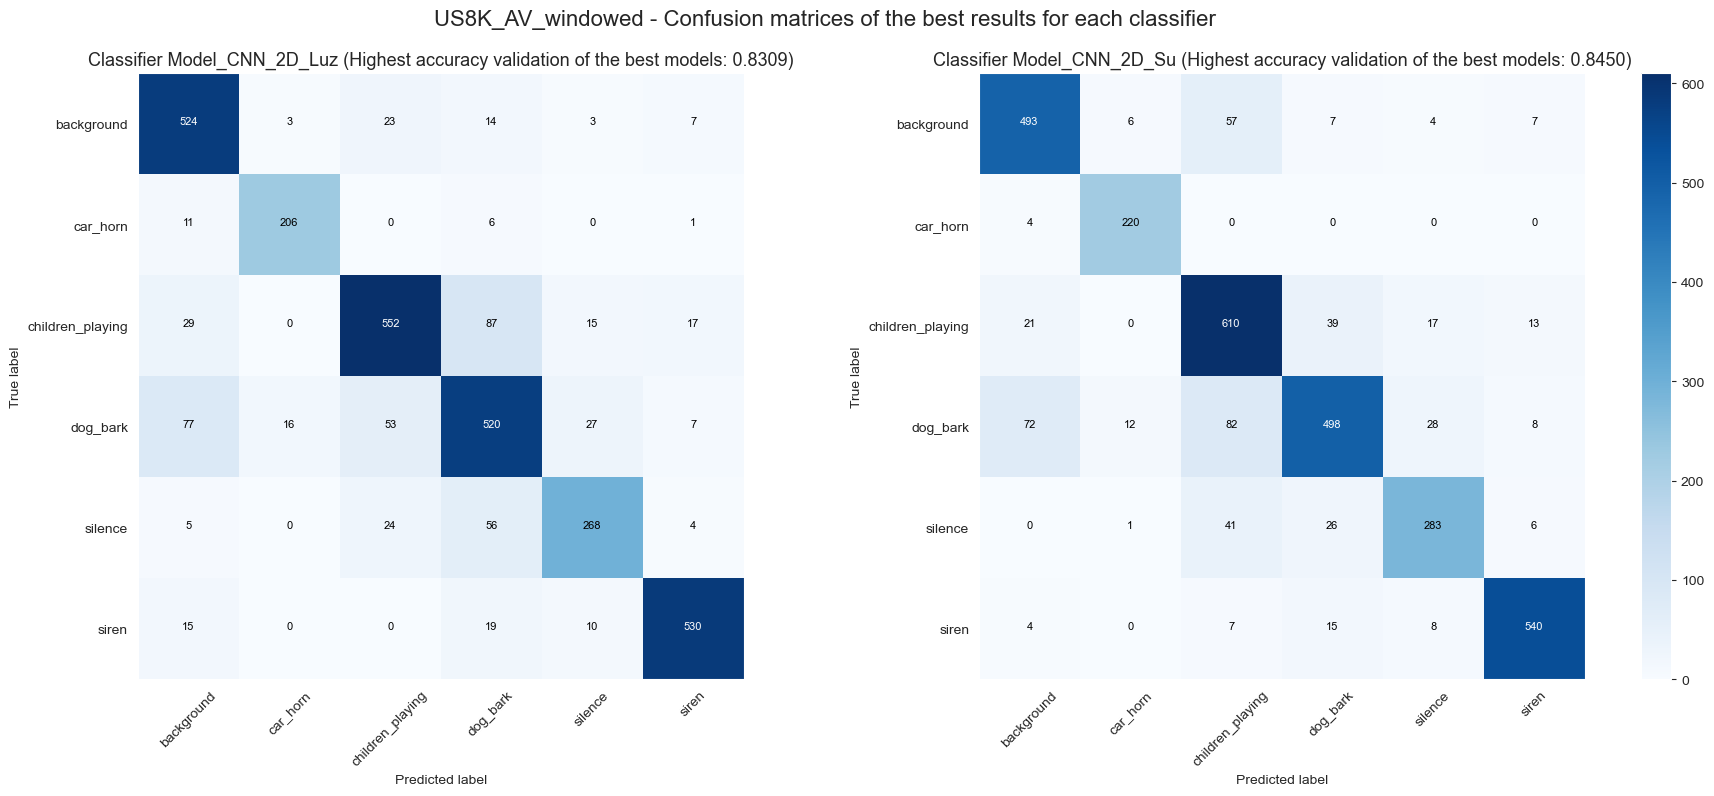

In [67]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(20,8))
plt.suptitle(nom_dataset + model_surname + ' - Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.99)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = 'Classifier '+ i + ' (Highest accuracy validation of the best models: ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Val)'])) +')'
    plt.subplot(1,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)

plt.savefig(os.path.join(path_pic, picture_name))
plt.tight_layout()

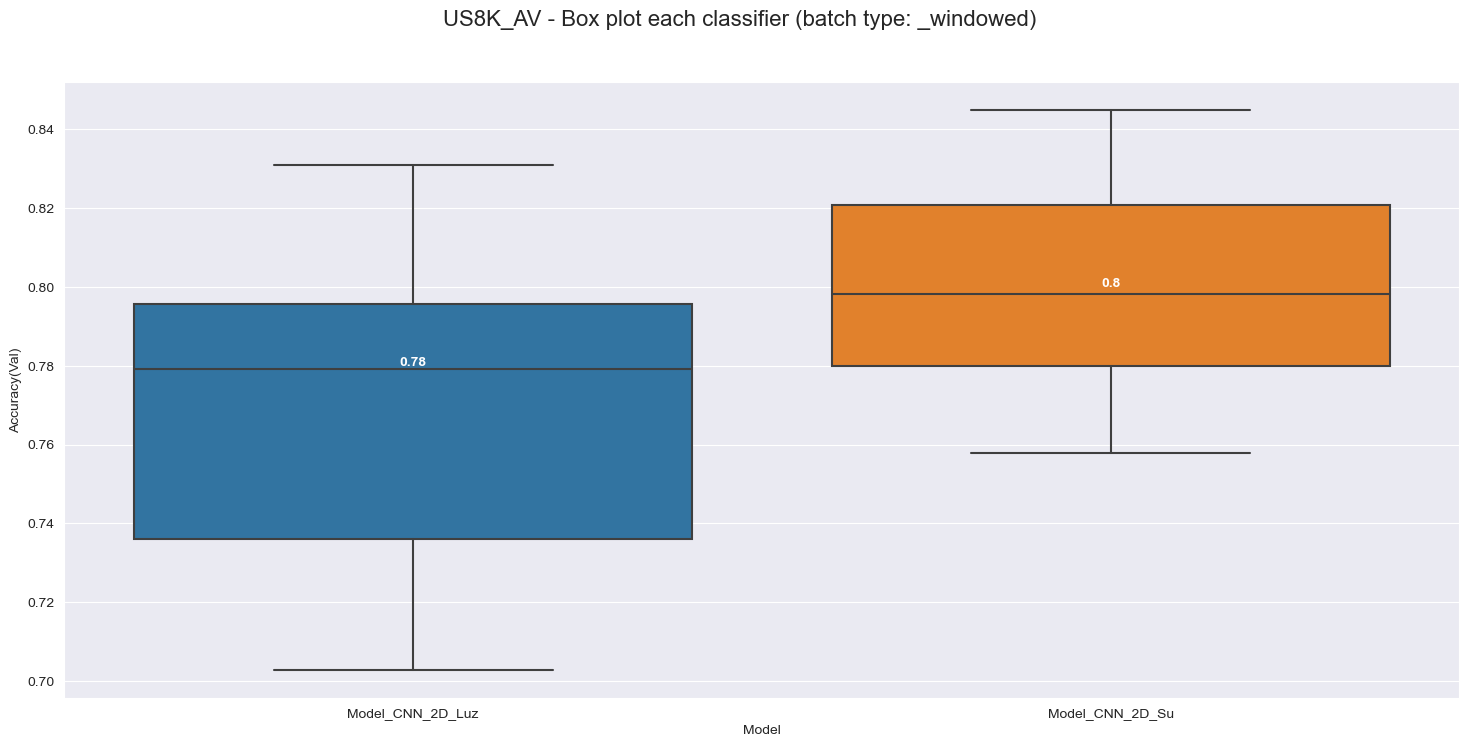

In [68]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Val)", showfliers = True)

medians = list(metrics_set.groupby(['Model'])['Accuracy(Val)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Val)'].median()*0.0001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

# End of the notebook